In [1]:
%matplotlib inline


import os

import Bio.AlignIO
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from scipy import stats

import prointvar.library
import prointvar.merger
import varalign.alignments
import varalign.align_variants
import varalign.prointvar_analysis

from proteofav.annotation import Annotation
from prointvar.fetchers import download_structure_from_pdbe, download_sifts_from_ebi

import covid_project_utils as my

In [2]:
# Setting Logging Level (adapted from TBBs)
from varalign.config import logging
logger = logging.getLogger()
assert len(logger.handlers) == 1
handler = logger.handlers[0]
handler.setLevel(logging.WARNING)

In [3]:
params = {
    'ace2_acc': 'Q9BYF1'
}

Start off by getting variants for ACE2...

In [4]:
aln = Bio.AlignIO.read('ACE2_HUMAN.fa', format='fasta')
# Provide annotations required by certain varalign functions
aln[0].annotations.update({'accession': 'Q9BYF1',
                           'start': 1,
                           'end': 805})
print(aln)

SingleLetterAlphabet() alignment with 1 rows and 805 columns
MSSSSWLLLSLVAVTAAQSTIEEQAKTFLDKFNHEAEDLFYQSS...TSF ACE2_HUMAN/1-805


In [5]:
aln_info_df = varalign.alignments.alignment_info_table(aln)
aln_info_df

,seq_id,name,uniprot,start_end,mapping,species,uniprot_id,length
0,ACE2_HUMAN/1-805,ACE2_HUMAN/1-805,Q9BYF1,"(1, 805)","[(1, 1), (2, 2), (3, 3), (4, 4), (5, 5), (6, 6...",HUMAN/1-805,Q9BYF1,805


In [6]:
# some folders need to be present
os.makedirs('.varalign', exist_ok=True)
os.makedirs('results', exist_ok=True)

# align variants
vcf_path = 'PF01401/results/alignment_variants-sorted.vcf.gz'
aln_variants = varalign.align_variants.align_variants(aln_info_df,
                                                      path_to_vcf=vcf_path)

Parsing variants...: 100%|██████████| 1/1 [00:00<00:00,  3.87it/s]


Notes:
- Couldn't set path to VCF on external HDD in config because it contains spaces
- Managed to make it work with a symlink, but then ran into KeyError: 'CSQ'
- Tried the PF01401 VCF, needed to index it. This should have all the variants
  for this protein.


## Variant table

This is a lot easier to work with than the gnomAD browser. Let's see what we
have generally and then we'll look at missense in particular.

In [7]:
# dump to CSV
aln_variants.to_csv('notebook_output/ACE2_gnomAD_variants.csv')

### VEP annotations

The basics...

In [8]:
len(aln_variants.dropna(subset=[('Feature', '')]))

338

In [9]:
(aln_variants
#  [aln_variants[('Allele_INFO', 'AC')] > 0]
 [('VEP', 'Consequence')]
 .value_counts()
)

missense_variant                            229
synonymous_variant                           88
missense_variant&splice_region_variant       12
stop_gained&splice_region_variant             2
splice_region_variant&synonymous_variant      2
frameshift_variant                            2
stop_gained                                   1
start_lost                                    1
inframe_deletion                              1
Name: (VEP, Consequence), dtype: int64

Some more details on the variability of ACE2

In [10]:
(aln_variants
 [aln_variants[('Allele_INFO', 'AF')] < 10e-5]
 [('VEP', 'Consequence')]
 .value_counts()
)

missense_variant                            214
synonymous_variant                           83
missense_variant&splice_region_variant       10
stop_gained&splice_region_variant             2
splice_region_variant&synonymous_variant      2
frameshift_variant                            2
stop_gained                                   1
start_lost                                    1
inframe_deletion                              1
Name: (VEP, Consequence), dtype: int64

In [11]:
(aln_variants
 [aln_variants[('Allele_INFO', 'AF_NFE')] < 10e-3]  # at 10e-2 there are more synonymous than missense
 .groupby(('VEP', 'Consequence'))
 [[('Allele_INFO', 'AC_NFE')]]
 .sum()
)

Type,Allele_INFO
Field,AC_NFE
"(VEP, Consequence)",
frameshift_variant,1.0
inframe_deletion,1.0
missense_variant,1007.0
missense_variant&splice_region_variant,55.0
splice_region_variant&synonymous_variant,0.0
start_lost,0.0
stop_gained,0.0
stop_gained&splice_region_variant,0.0


What columns are empty?

In [12]:
is_empty = [(column, (aln_variants[column].fillna('') == '').all())
            for column in aln_variants]
is_empty = pd.DataFrame(is_empty, columns=('column', 'is_empty'))
is_empty.set_index('column', inplace=True)
print(is_empty[is_empty.values])
# aln_variants.loc[:, ~is_empty.values]

2020-04-28 01:18:28,804 py.warnings  WARNING  /Users/smacgowan/miniconda3/envs/varalign-nCoV/lib/python3.6/site-packages/pandas/core/ops/array_ops.py:253: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  res_values = method(rvalues)



                           is_empty
column                             
(VEP, INTRON)                  True
(VEP, DISTANCE)                True
(VEP, FLAGS)                   True
(VEP, TSL)                     True
(VEP, APPRIS)                  True
(VEP, TREMBL)                  True
(VEP, GENE_PHENO)              True
(VEP, HGVS_OFFSET)             True
(VEP, CLIN_SIG)                True
(VEP, PUBMED)                  True
(VEP, MOTIF_NAME)              True
(VEP, MOTIF_POS)               True
(VEP, HIGH_INF_POS)            True
(VEP, MOTIF_SCORE_CHANGE)      True
(VEP, LoF_filter)              True
(VEP, LoF_flags)               True


There are some PHENO and SOMATIC annotations but I don't know what these mean.

In [13]:
aln_variants[('VEP', 'PHENO')].value_counts()  # all empty

         313
0&1       19
1          5
0&1&1      1
Name: (VEP, PHENO), dtype: int64

In [14]:
aln_variants[('VEP', 'SOMATIC')].value_counts()

         313
0&1       19
1          5
0&1&1      1
Name: (VEP, SOMATIC), dtype: int64

Notes:
- no annotations in CLIN_SIG, GENE_PHENO (see what columns are empty?)
- Potentially useful columns in aln_variants['VEP'].columns

## Missense variants

In [15]:
aln_variants.columns.tolist()

[('Alignment', 'Column'),
 ('SITE', ''),
 ('ALLELE_NUM', ''),
 ('Feature', ''),
 ('Row', 'ID'),
 ('Row', 'CHROM'),
 ('Row', 'POS'),
 ('Row', 'REF'),
 ('Row', 'ALT'),
 ('Row', 'QUAL'),
 ('Row', 'FILTER'),
 ('Site_INFO', 'AN'),
 ('Site_INFO', 'BaseQRankSum'),
 ('Site_INFO', 'ClippingRankSum'),
 ('Site_INFO', 'DP'),
 ('Site_INFO', 'FS'),
 ('Site_INFO', 'InbreedingCoeff'),
 ('Site_INFO', 'MQ'),
 ('Site_INFO', 'MQRankSum'),
 ('Site_INFO', 'QD'),
 ('Site_INFO', 'ReadPosRankSum'),
 ('Site_INFO', 'SOR'),
 ('Site_INFO', 'VQSLOD'),
 ('Site_INFO', 'VQSR_culprit'),
 ('Site_INFO', 'GQ_HIST_ALL'),
 ('Site_INFO', 'DP_HIST_ALL'),
 ('Site_INFO', 'AB_HIST_ALL'),
 ('Site_INFO', 'AN_AFR'),
 ('Site_INFO', 'AN_AMR'),
 ('Site_INFO', 'AN_ASJ'),
 ('Site_INFO', 'AN_EAS'),
 ('Site_INFO', 'AN_FIN'),
 ('Site_INFO', 'AN_NFE'),
 ('Site_INFO', 'AN_OTH'),
 ('Site_INFO', 'AN_SAS'),
 ('Site_INFO', 'AN_Male'),
 ('Site_INFO', 'AN_Female'),
 ('Site_INFO', 'AN_raw'),
 ('Site_INFO', 'STAR_AC'),
 ('Site_INFO', 'STAR_AC_raw'),

In [16]:
is_missense = (aln_variants[('VEP', 'Consequence')].str.contains('missense')
               .fillna(False)
              )
mvps = [('Row', 'ID'), ('Row', 'FILTER'),
        ('VEP', 'HGVSp'),
        ('Site_INFO', 'AN'),
        ('Allele_INFO', 'AC'),
        ('Allele_INFO', 'Hom'), ('Allele_INFO', 'AC_Male'), ('Allele_INFO', 'Hemi'), # cf. AC to spot X-linking
        ('Allele_INFO', 'POPMAX'), ('Allele_INFO', 'AC_POPMAX'),  # cf. AC to identify popn specificity
       ]
aln_variants.loc[is_missense, mvps]

Type                                       Row         \
Field                                       ID FILTER   
SOURCE_ID        Protein_position                       
ACE2_HUMAN/1-805 2                 rs760347219     []   
                 3                        None     []   
                 8                 rs201035388     []   
                 9                 rs746202722   [RF]   
                 19                 rs73635825     []   
...                                        ...    ...   
                 796                      None     []   
                 798                      None     []   
                 801                      None     []   
                 804               rs771107251     []   
                 805               rs749525058     []   

Type                                                         VEP Site_INFO  \
Field                                                      HGVSp        AN   
SOURCE_ID        Protein_position                                            
ACE2_HUMAN/1-805 2                   ENSP00000389326.1:p.Ser2Pro  165563.0   
                 3                   ENSP00000389326.1:p.Ser3Asn  167014.0   
                 8                   ENSP00000389326.1:p.Leu8Phe  172173.0   
                 9                   ENSP00000389326.1:p.Leu9Pro  173118.0   
                 19                 ENSP00000389326.1:p.Ser19Pro  178042.0   
...                                                          ...       ...   
                 796               ENSP00000389326.1:p.Gln796Arg  175068.0   
                 798               ENSP00000389326.1:p.Thr798Ser  175150.0   
                 801               ENSP00000389326.1:p.Val801Gly  173474.0   
                 804               ENSP00000389326.1:p.Ser804Phe  167994.0   
                 805               ENSP00000389326.1:p.Phe805Ile  167923.0   

Type                              Allele_INFO                           \
Field                                      AC  Hom AC_Male Hemi POPMAX   
SOURCE_ID        Protein_position                                        
ACE2_HUMAN/1-805 2                        1.0  0.0     0.0  0.0    AMR   
                 3                        1.0  0.0     0.0  0.0    SAS   
                 8                       13.0  0.0     5.0  5.0    AFR   
                 9                        1.0  0.0     0.0  0.0    NFE   
                 19                      40.0  0.0     6.0  6.0    AFR   
...                                       ...  ...     ...  ...    ...   
                 796                      2.0  0.0     1.0  1.0    NFE   
                 798                      1.0  0.0     1.0  1.0    NFE   
                 801                      1.0  0.0     0.0  0.0    SAS   
                 804                      1.0  0.0     0.0  0.0    AFR   
                 805                      4.0  0.0     1.0  1.0    NFE   

Type                                         
Field                             AC_POPMAX  
SOURCE_ID        Protein_position            
ACE2_HUMAN/1-805 2                      1.0  
                 3                      1.0  
                 8                      2.0  
                 9                      1.0  
                 19                    39.0  
...                                     ...  
                 796                    2.0  
                 798                    1.0  
                 801                    1.0  
                 804                    1.0  
                 805                    4.0  

[241 rows x 10 columns]

## Other LoF

In [17]:
is_synonymous = (aln_variants[('VEP', 'Consequence')].str.contains('synonymous')
                 .fillna(False)
                )
other_lof = (aln_variants
             .loc[~(is_missense | is_synonymous)]
             .dropna(subset=[('SITE', '')])
             [[('VEP', 'Consequence')] + mvps]
            )
my.variant_report_table(other_lof, 'notebook_output/other_lof_variants.csv')

ID            Mutation  \
SOURCE_ID        Protein_position                                    
ACE2_HUMAN/1-805 1                 rs768110251             p.Met1?   
                 116                         -         p.Leu116Ter   
                 313                         -         p.Lys313del   
                 422                         -  p.Gly422ValfsTer15   
                 514                         -         p.Arg514Ter   
                 656               rs199951323         p.Leu656Ter   
                 702                         -  p.Lys702ArgfsTer16   

                                   Allele Count  AC Male  AC Popn. Max  \
SOURCE_ID        Protein_position                                        
ACE2_HUMAN/1-805 1                            1        0             1   
                 116                          1        0             1   
                 313                          1        1             1   
                 422                          1        0             1   
                 514                          1        0             1   
                 656                          1        0             1   
                 702                          0        0             0   

                                  Popn. Max  
SOURCE_ID        Protein_position            
ACE2_HUMAN/1-805 1                      ASJ  
                 116                    ASJ  
                 313                    NFE  
                 422                    NFE  
                 514                    FIN  
                 656                    EAS  
                 702                   None

## Common variants

In [18]:
(aln_variants
 .sort_values(by=('Allele_INFO', 'AC'), ascending=False)
 [mvps + [('VEP', 'Consequence')]]
 .head(10)
)

Type                                       Row         \
Field                                       ID FILTER   
SOURCE_ID        Protein_position                       
ACE2_HUMAN/1-805 749                rs35803318     []   
                 720                rs41303171     []   
                 690                 rs4646179     []   
                 26                  rs4646116     []   
                 211               rs148771870     []   
                 731               rs147311723     []   
                 468               rs191860450     []   
                 34                rs368655410     []   
                 351               rs147464721     []   
                 692               rs149039346     []   

Type                                                              VEP  \
Field                                                           HGVSp   
SOURCE_ID        Protein_position                                       
ACE2_HUMAN/1-805 749               ENST00000427411.1:c.2247G>A(p.%3D)   
                 720                    ENSP00000389326.1:p.Asn720Asp   
                 690               ENST00000427411.1:c.2070T>C(p.%3D)   
                 26                      ENSP00000389326.1:p.Lys26Arg   
                 211                    ENSP00000389326.1:p.Gly211Arg   
                 731                    ENSP00000389326.1:p.Leu731Phe   
                 468                    ENSP00000389326.1:p.Ile468Val   
                 34                 ENST00000427411.1:c.102C>T(p.%3D)   
                 351               ENST00000427411.1:c.1051C>T(p.%3D)   
                 692                    ENSP00000389326.1:p.Ser692Pro   

Type                              Site_INFO Allele_INFO                 \
Field                                    AN          AC    Hom AC_Male   
SOURCE_ID        Protein_position                                        
ACE2_HUMAN/1-805 749               168539.0      6631.0  171.0  2081.0   
                 720               162297.0      2663.0   27.0   933.0   
                 690               178064.0       949.0   22.0   231.0   
                 26                178640.0       704.0    0.0   258.0   
                 211               178343.0       243.0    0.0    91.0   
                 731               173229.0       195.0    1.0    49.0   
                 468               173909.0       142.0    1.0    40.0   
                 34                178668.0       111.0    0.0    39.0   
                 351               170592.0        82.0    0.0    16.0   
                 692               178054.0        68.0    0.0    14.0   

Type                                                                       VEP  
Field                                Hemi POPMAX AC_POPMAX         Consequence  
SOURCE_ID        Protein_position                                               
ACE2_HUMAN/1-805 749               2081.0    ASJ     691.0  synonymous_variant  
                 720                933.0    FIN     443.0    missense_variant  
                 690                231.0    AFR     778.0  synonymous_variant  
                 26                 258.0    ASJ      85.0    missense_variant  
                 211                 91.0    NFE     165.0    missense_variant  
                 731                 49.0    AFR     180.0    missense_variant  
                 468                 40.0    EAS     138.0    missense_variant  
                 34                  39.0    FIN      52.0  synonymous_variant  
                 351                 16.0    AFR      69.0  synonymous_variant  
                 692                 14.0    AFR      64.0    missense_variant

Check for ClinVar missense

In [19]:
# K26R present
# A214V mot present, NM_001320866.2:c.641C>T
# aln_variants.loc[('ACE2_HUMAN/1-805', 214), mvps]

## UniProt annotations from ProteoFAV

In [20]:
# create tmp dir
out_dir = os.path.join(os.getcwd(), "proteofav_db")
os.makedirs(out_dir, exist_ok=True)

out_annotation = os.path.join(out_dir, "{}.gff".format(params['ace2_acc']))
# Annotation.download(identifier=params['ace2_acc'], filename=out_annotation)
assert os.path.exists(out_annotation)
annotation = Annotation.read(filename=out_annotation)
annotation

,NAME,SOURCE,TYPE,START,END,SCORE,STRAND,FRAME,GROUP,Ontology_term,evidence,ID,Note,Dbxref
0,Q9BYF1,UniProtKB,Signal peptide,1,17,.,.,.,Ontology_term=ECO:0000255;evidence=ECO:0000255,[ECO:0000255],[ECO:0000255],NaN,NaN,NaN
1,Q9BYF1,UniProtKB,Chain,18,805,.,.,.,ID=PRO_0000028570;Note=Angiotensin-converting ...,NaN,NaN,[PRO_0000028570],[Angiotensin-converting enzyme 2],NaN
2,Q9BYF1,UniProtKB,Chain,18,708,.,.,.,ID=PRO_0000292268;Note=Processed angiotensin-c...,NaN,NaN,[PRO_0000292268],[Processed angiotensin-converting enzyme 2],NaN
3,Q9BYF1,UniProtKB,Topological domain,18,740,.,.,.,Note=Extracellular;Ontology_term=ECO:0000255;e...,[ECO:0000255],[ECO:0000255],NaN,[Extracellular],NaN
4,Q9BYF1,UniProtKB,Transmembrane,741,761,.,.,.,Note=Helical;Ontology_term=ECO:0000255;evidenc...,[ECO:0000255],[ECO:0000255],NaN,[Helical],NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
123,Q9BYF1,UniProtKB,Helix,566,574,.,.,.,Ontology_term=ECO:0000244;evidence=ECO:0000244...,[ECO:0000244],[ECO:0000244|PDB:1R42],NaN,NaN,NaN
124,Q9BYF1,UniProtKB,Beta strand,575,578,.,.,.,Ontology_term=ECO:0000244;evidence=ECO:0000244...,[ECO:0000244],[ECO:0000244|PDB:1R42],NaN,NaN,NaN
125,Q9BYF1,UniProtKB,Helix,582,598,.,.,.,Ontology_term=ECO:0000244;evidence=ECO:0000244...,[ECO:0000244],[ECO:0000244|PDB:1R42],NaN,NaN,NaN
126,Q9BYF1,UniProtKB,Beta strand,600,602,.,.,.,Ontology_term=ECO:0000244;evidence=ECO:0000244...,[ECO:0000244],[ECO:0000244|PDB:1R42],NaN,NaN,NaN


In [21]:
annotation['TYPE'].value_counts()

Helix                   32
Mutagenesis             30
Beta strand             13
Turn                    12
Binding site             8
Glycosylation            7
Region                   5
Disulfide bond           3
Sequence conflict        3
Metal binding            3
Active site              2
Chain                    2
Natural variant          2
Topological domain       2
Alternative sequence     2
Transmembrane            1
Signal peptide           1
Name: TYPE, dtype: int64

Process region data. This includes TMPRSS2 cleavage annotations and others.

In [22]:
regions = annotation.query('TYPE == "Region"')
regions = pd.concat([regions, regions['Note'].str[0].str.split('\. ', expand=True)], axis=1)
regions = regions.rename(columns={0: 'region'})
regions

,NAME,SOURCE,TYPE,START,END,SCORE,STRAND,FRAME,GROUP,Ontology_term,evidence,ID,Note,Dbxref,region
6,Q9BYF1,UniProtKB,Region,30,41,.,.,.,Note=Interaction with SARS-CoV spike glycoprotein,NaN,NaN,NaN,[Interaction with SARS-CoV spike glycoprotein],NaN,Interaction with SARS-CoV spike glycoprotein
7,Q9BYF1,UniProtKB,Region,82,84,.,.,.,Note=Interaction with SARS-CoV spike glycoprotein,NaN,NaN,NaN,[Interaction with SARS-CoV spike glycoprotein],NaN,Interaction with SARS-CoV spike glycoprotein
8,Q9BYF1,UniProtKB,Region,353,357,.,.,.,Note=Interaction with SARS-CoV spike glycoprotein,NaN,NaN,NaN,[Interaction with SARS-CoV spike glycoprotein],NaN,Interaction with SARS-CoV spike glycoprotein
9,Q9BYF1,UniProtKB,Region,652,659,.,.,.,Note=Essential for cleavage by ADAM17,NaN,NaN,NaN,[Essential for cleavage by ADAM17],NaN,Essential for cleavage by ADAM17
10,Q9BYF1,UniProtKB,Region,697,716,.,.,.,Note=Essential for cleavage by TMPRSS11D and T...,NaN,NaN,NaN,[Essential for cleavage by TMPRSS11D and TMPRSS2],NaN,Essential for cleavage by TMPRSS11D and TMPRSS2


In [23]:
regions['region']

6        Interaction with SARS-CoV spike glycoprotein
7        Interaction with SARS-CoV spike glycoprotein
8        Interaction with SARS-CoV spike glycoprotein
9                    Essential for cleavage by ADAM17
10    Essential for cleavage by TMPRSS11D and TMPRSS2
Name: region, dtype: object

Quick look at variants in TMPRSS2 region

In [24]:
TMPRSS2_region = pd.RangeIndex(697, 716)
TMPRSS2_variants = (aln_variants
                    .loc['ACE2_HUMAN/1-805']
                    .loc[TMPRSS2_region, mvps]
                    .dropna(how='all')
                   )
my.variant_report_table(TMPRSS2_variants, 'notebook_output/TMPRSS2_variants.csv')

,ID,Mutation,Allele Count,AC Male,AC Popn. Max,Popn. Max
Protein_position,,,,,,
697,rs751603885,p.Arg697Gly,46,35,45,SAS
702,-,p.Lys702ArgfsTer16,0,0,0,None
703,rs780128908,p.Ala703Ser,3,0,3,NFE
706,rs372986872,p.Met706Ile,1,0,1,NFE
708,rs769062069,p.Arg708Gln,1,1,1,NFE
708,rs776995986,p.Arg708Trp,1,0,1,NFE
709,-,p.Ser709Arg,1,0,1,NFE
710,rs370187012,p.Arg710His,7,2,2,EAS
710,-,p.Arg710Cys,3,0,1,EAS


And the ADAM17 region

In [25]:
ADAM17_region = pd.RangeIndex(652, 659)
ADAM17_variants = (aln_variants
                   .loc['ACE2_HUMAN/1-805']
                   .loc[ADAM17_region, mvps]
                   .dropna(how='all')
                  )
my.variant_report_table(ADAM17_variants, 'notebook_output/ADAM17_variants.csv')

,ID,Mutation,Allele Count,AC Male,AC Popn. Max,Popn. Max
Protein_position,,,,,,
652,-,p.Arg652Lys,1,0,1,NFE
653,rs774412370,c.1959G>A(p.%3D),1,0,1,EAS
656,rs199951323,p.Leu656Ter,1,0,1,EAS
658,-,c.1974A>G(p.%3D),1,0,1,AMR
658,-,p.Val658Ile,1,0,1,EAS


Process the mutagenesis data

In [26]:
mutants = annotation.query('TYPE == "Mutagenesis"')
mutants = pd.concat([mutants, mutants['Note'].str[0].str.split('\. ', expand=True)], axis=1)
mutants = mutants.rename(columns={0: 'effect', 1: 'mutant'})
mutants

,NAME,SOURCE,TYPE,START,END,SCORE,STRAND,FRAME,GROUP,Ontology_term,evidence,ID,Note,Dbxref,effect,mutant
38,Q9BYF1,UniProtKB,Mutagenesis,24,26,.,.,.,Note=Slightly inhibits interaction with SARS-C...,[ECO:0000269],[ECO:0000269|PubMed:15791205],NaN,[Slightly inhibits interaction with SARS-CoV s...,[PMID:15791205],Slightly inhibits interaction with SARS-CoV sp...,QAK->KAE
39,Q9BYF1,UniProtKB,Mutagenesis,31,31,.,.,.,Note=Abolishes interaction with SARS-CoV spike...,[ECO:0000269],[ECO:0000269|PubMed:15791205],NaN,[Abolishes interaction with SARS-CoV spike gly...,[PMID:15791205],Abolishes interaction with SARS-CoV spike glyc...,K->D
40,Q9BYF1,UniProtKB,Mutagenesis,37,37,.,.,.,Note=No effect on interaction with SARS-CoV sp...,[ECO:0000269],[ECO:0000269|PubMed:15791205],NaN,[No effect on interaction with SARS-CoV spike ...,[PMID:15791205],No effect on interaction with SARS-CoV spike g...,E->A
41,Q9BYF1,UniProtKB,Mutagenesis,38,38,.,.,.,Note=No effect on interaction with SARS-CoV sp...,[ECO:0000269],[ECO:0000269|PubMed:15791205],NaN,[No effect on interaction with SARS-CoV spike ...,[PMID:15791205],No effect on interaction with SARS-CoV spike g...,D->A
42,Q9BYF1,UniProtKB,Mutagenesis,41,41,.,.,.,Note=Strongly inhibits interaction with SARS-C...,[ECO:0000269],[ECO:0000269|PubMed:15791205],NaN,[Strongly inhibits interaction with SARS-CoV s...,[PMID:15791205],Strongly inhibits interaction with SARS-CoV sp...,Y->A
43,Q9BYF1,UniProtKB,Mutagenesis,68,68,.,.,.,Note=Slightly inhibits interaction with SARS-C...,[ECO:0000269],[ECO:0000269|PubMed:15791205],NaN,[Slightly inhibits interaction with SARS-CoV s...,[PMID:15791205],Slightly inhibits interaction with SARS-CoV sp...,K->D
44,Q9BYF1,UniProtKB,Mutagenesis,82,84,.,.,.,Note=Inhibits interaction with SARS-CoV spike ...,[ECO:0000269],[ECO:0000269|PubMed:15791205],NaN,[Inhibits interaction with SARS-CoV spike glyc...,[PMID:15791205],Inhibits interaction with SARS-CoV spike glyco...,MYP->NFS
45,Q9BYF1,UniProtKB,Mutagenesis,110,110,.,.,.,Note=No effect on interaction with SARS-CoV sp...,[ECO:0000269],[ECO:0000269|PubMed:15791205],NaN,[No effect on interaction with SARS-CoV spike ...,[PMID:15791205],No effect on interaction with SARS-CoV spike g...,E->P
46,Q9BYF1,UniProtKB,Mutagenesis,135,136,.,.,.,Note=No effect on interaction with SARS-CoV sp...,[ECO:0000269],[ECO:0000269|PubMed:15791205],NaN,[No effect on interaction with SARS-CoV spike ...,[PMID:15791205],No effect on interaction with SARS-CoV spike g...,PD->SM
47,Q9BYF1,UniProtKB,Mutagenesis,160,160,.,.,.,Note=No effect on interaction with SARS-CoV sp...,[ECO:0000269],[ECO:0000269|PubMed:15791205],NaN,[No effect on interaction with SARS-CoV spike ...,[PMID:15791205],No effect on interaction with SARS-CoV spike g...,E->R


In [27]:
mutants['effect'].value_counts()

No effect on interaction with SARS-CoV spike glycoprotein         16
Slightly inhibits interaction with SARS-CoV spike glycoprotein     7
Strongly inhibits interaction with SARS-CoV spike glycoprotein     3
Abolishes interaction with SARS-CoV spike glycoprotein             2
Inhibits interaction with SARS-CoV spike glycoprotein              1
Does not affect amino acid transport activity of SLC6A19           1
Name: effect, dtype: int64

NB. I'll leave in the "transport activity of SLC6A19" mutant for interest.

Some entries report multiple mutant residues. For example, mutants at position
353 indicate the format: "K->H,A,D".

The simplest thing to do is to expand these into multiple rows.

In [28]:
# select rows with multiple mutants
mutant_is_collapsed = mutants['mutant'].str.contains(',')
mutants_collapsed = mutants.loc[mutant_is_collapsed, :]
assert(len(mutants_collapsed)) == 2  # expect only positions 353 and 359, only True on first execution
# Parse mutant and expand rows to one row per mutant
mutants_collapsed[['wt', 'mutants']] = mutants_collapsed['mutant'].str.split('->', expand=True)  # split wt/mutant
mutants_expanded = mutants_collapsed.join(mutants_collapsed['mutants']
                                          .str.split(',', expand=True)
                                          .stack()
                                          .reset_index(level=1)
                                         )
# conform format to original
mutants_expanded.loc[:, 'mutant'] = mutants_expanded['wt'] + '->' + mutants_expanded[0]
mutants_expanded = mutants_expanded.drop(columns=['wt', 'mutants', 'level_1', 0])
logging.debug(mutants_expanded[['START', 'mutant']])  # weird, debug suppresses SettingWithCopyWarning
# replace the collapsed entries with these expanded versions
mutants = mutants[~mutant_is_collapsed]  # drop collapsed
mutants = pd.concat([mutants, mutants_expanded])
mutants[mutant_is_collapsed]  # relies on Boolean reindexing

2020-04-28 01:18:29,805 py.warnings  WARNING  /Users/smacgowan/miniconda3/envs/varalign-nCoV/lib/python3.6/site-packages/pandas/core/frame.py:2963: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]

2020-04-28 01:18:29,816 py.warnings  WARNING  /Users/smacgowan/miniconda3/envs/varalign-nCoV/lib/python3.6/site-packages/ipykernel_launcher.py:19: UserWarning: Boolean Series key will be reindexed to match DataFrame index.



,NAME,SOURCE,TYPE,START,END,SCORE,STRAND,FRAME,GROUP,Ontology_term,evidence,ID,Note,Dbxref,effect,mutant
57,Q9BYF1,UniProtKB,Mutagenesis,353,353,.,.,.,Note=Abolishes interaction with SARS-CoV spike...,[ECO:0000269],[ECO:0000269|PubMed:15791205],NaN,[Abolishes interaction with SARS-CoV spike gly...,[PMID:15791205],Abolishes interaction with SARS-CoV spike glyc...,K->H
57,Q9BYF1,UniProtKB,Mutagenesis,353,353,.,.,.,Note=Abolishes interaction with SARS-CoV spike...,[ECO:0000269],[ECO:0000269|PubMed:15791205],NaN,[Abolishes interaction with SARS-CoV spike gly...,[PMID:15791205],Abolishes interaction with SARS-CoV spike glyc...,K->A
57,Q9BYF1,UniProtKB,Mutagenesis,353,353,.,.,.,Note=Abolishes interaction with SARS-CoV spike...,[ECO:0000269],[ECO:0000269|PubMed:15791205],NaN,[Abolishes interaction with SARS-CoV spike gly...,[PMID:15791205],Abolishes interaction with SARS-CoV spike glyc...,K->D
60,Q9BYF1,UniProtKB,Mutagenesis,359,359,.,.,.,Note=No effect on interaction with SARS-CoV sp...,[ECO:0000269],[ECO:0000269|PubMed:15791205],NaN,[No effect on interaction with SARS-CoV spike ...,[PMID:15791205],No effect on interaction with SARS-CoV spike g...,L->K
60,Q9BYF1,UniProtKB,Mutagenesis,359,359,.,.,.,Note=No effect on interaction with SARS-CoV sp...,[ECO:0000269],[ECO:0000269|PubMed:15791205],NaN,[No effect on interaction with SARS-CoV spike ...,[PMID:15791205],No effect on interaction with SARS-CoV spike g...,L->A


Note:
- I could apply this routine to all mutants and it could be designed to leave single
  mutants untouched. This would have the advantage of taking care of the mutant
  parsing here and avoid having to do it later.

## Variants at sites with Mutant Assays

For a first pass I'll merge only missense and single-point mutants. Later on
I can handle double, triple mutants etc. and frameshifts and the like.

In [29]:
variants_at_assayed_sites = pd.merge(my.variant_report_table(aln_variants.loc[is_missense, mvps]),
                                     mutants[['START', 'END', 'effect', 'mutant']],
                                     left_on='Protein_position', right_on='START')
variants_at_assayed_sites['effect'] = my.categorise_mutagenesis_assays(variants_at_assayed_sites['effect'])
variants_at_assayed_sites.to_csv('notebook_output/variants_at_assayed_sites.csv')
variants_at_assayed_sites

,ID,Mutation,Allele Count,AC Male,AC Popn. Max,Popn. Max,START,END,effect,mutant
0,rs146676783,p.Glu37Lys,6,3,5,FIN,37,37,No effect,E->A
1,rs755691167,p.Lys68Glu,2,2,2,SAS,68,68,Slightly inhibits,K->D
2,rs766996587,p.Met82Ile,0,0,0,None,82,84,Inhibits,MYP->NFS
3,rs766996587,p.Met82Ile,2,0,2,AFR,82,84,Inhibits,MYP->NFS
4,rs759590772,p.Arg219His,18,11,17,SAS,219,219,No effect,R->D
5,rs372272603,p.Arg219Cys,58,17,52,NFE,219,219,No effect,R->D
6,-,p.His239Gln,1,0,1,NFE,239,239,No effect,H->Q
7,rs780574871,p.Glu312Lys,3,1,2,AFR,312,312,No effect,E->A
8,-,p.Asn338Ser,3,1,2,AMR,338,340,No effect,NVQ->DDR
9,-,p.Asp355Asn,2,0,2,NFE,355,355,Strongly inhibits,D->A


# Structure data

Will use ProIntVar methods directly as much as possible and then the post-processing I have in VarAlign
if required.

In [30]:
download_structure_from_pdbe('6vw1')
download_sifts_from_ebi('6vw1')

Using prointvar.merger...

In [31]:
mmcif_table, dssp_table, sifts_table, contacts_table = \
prointvar.merger.table_generator(pdb_id='6vw1', bio=False, dssp=True, dssp_unbound=True,
                                 contacts=True)

# DSSP table needs a little re-formatting
# dssp_table.dtypes
dssp_table.loc[:, 'RSA'] = pd.to_numeric(dssp_table['RSA'])  # `astype(float)` complains about strings...
dssp_table.loc[:, 'RSA_UNB'] = dssp_table['RSA_UNB'].astype(float)

# Add amino acids to contacts from mmcif table as missing
resnames = mmcif_table[['label_atom_id', 'label_comp_id', 'auth_asym_id', 'auth_seq_id']].copy()
# label A atoms
resnames.columns = resnames.columns + '_A'
resnames_keys = ['label_atom_id', 'auth_asym_id', 'auth_seq_id']
resnames_keys = [s + '_A' for s in resnames_keys]
contacts_keys = ['ATOM_A', 'CHAIN_A', 'RES_FULL_A']
contacts_table = (pd.merge(resnames, contacts_table, left_on=resnames_keys, right_on=contacts_keys)
                  .drop(columns=resnames_keys)
                 )
# label B atoms
resnames.columns = [s.replace('_A', '_B') for s in resnames.columns]
resnames_keys = [s.replace('_A', '_B') for s in resnames_keys]
contacts_keys = [s.replace('_A', '_B') for s in contacts_keys]
contacts_table = (pd.merge(resnames, contacts_table, left_on=resnames_keys, right_on=contacts_keys)
                  .drop(columns=resnames_keys)
                 )
# 3-to-1 letter codes
contacts_table['resn_A'] = contacts_table['label_comp_id_A'].map(prointvar.library.aa_codes_3to1_common)
contacts_table['resn_B'] = contacts_table['label_comp_id_B'].map(prointvar.library.aa_codes_3to1_common)

Notes:
- `prointvar.merger.table_generator` yields TypeError if called with UniProt ID
- `prointvar.merger.table_generator` yields OSError if bio=True
- `prointvar.merger.table_generator` yields KeyError...
- Needed to fix KeyError: "['Cartn_x_esd' 'Cartn_y_esd' 'Cartn_z_esd' 'occupancy_esd'\n 'B_iso_or_equiv_esd'] not found in axis"

Might be cleaner to use PDBX, SIFTS and Contacts tables seperately but for
now I'll stick to using `table_generator` for convenience.

## ACE2-nCoV Spike Interface

Chains A,B are ACE2 whilst E,F are 2019-nCoV chimeric RBD in the asymmetric unit.

I'll look at all interface contacts for now. I think the biological unit is one of the
heterodimers according to RCSB and PDBe. I've read that the ACE2 active form is a dimer,
so their could be mileage from inspecting both interfaces.

Side-note:
- UniProt topology annotations could be worth a look to check the interface is on the
  extracellular surface

In [32]:
contacts_table

,label_comp_id_B,label_comp_id_A,DIST,VDW_DIST,CHAIN_A,RES_FULL_A,ATOM_A,RES_A,INSCODE_A,CHAIN_B,RES_FULL_B,ATOM_B,RES_B,INSCODE_B,Int_Types,resn_A,resn_B
0,SER,GLN,4.766,1.666,A,24,NE2,24,?,A,19,N,19,?,{VDW-Proximal},Q,S
1,SER,GLN,4.403,1.153,A,24,NE2,24,?,A,19,CA,19,?,{VDW-Proximal},Q,S
2,SER,ILE,4.200,0.950,A,21,N,21,?,A,19,C,19,?,{VDW-Proximal},I,S
3,SER,GLN,4.788,1.388,A,24,CG,24,?,A,19,C,19,?,{VDW-Proximal},Q,S
4,SER,GLN,4.812,1.412,A,24,CD,24,?,A,19,C,19,?,{VDW-Proximal},Q,S
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
68812,HOH,ARG,4.128,0.908,F,439,C,439,?,F,701,O,701,?,{VDW-Proximal},R,NaN
68813,HOH,ARG,3.722,0.502,F,439,CB,439,?,F,701,O,701,?,{VDW-Proximal},R,NaN
68814,HOH,ASN,3.404,0.334,F,440,N,440,?,F,701,O,701,?,"{VDW-Proximal, Hydrogen-Bond, Polar-Bond}",N,NaN
68815,HOH,ASN,4.376,1.156,F,440,CA,440,?,F,701,O,701,?,{VDW-Proximal},N,NaN


There are two observed ACE2-nCoV interfaces. A-E and B-F. A-E has more contacts so
I guess this is what the predicted biological unit is (guess!).

In [33]:
pd.crosstab(contacts_table['CHAIN_A'], contacts_table['CHAIN_B'])

CHAIN_B,A,B,E,F
CHAIN_A,,,,
A,27017,32,285,0
B,35,27057,0,263
E,206,0,6931,0
F,0,199,0,6792


Note:
- the chain A/B contingency table is asymmetric

I will need to compare the interfaces to see if I can work with one or need to consider both.

Assuming the numbering is the same for each equivalent molecule I can compare the interfaces
by the residue numbers. I could do this at atom level but it is slightly more complicated
and I don't think I'd gain much.

In [34]:
# check that the numbering is the same for each equivalent molecule of ACE2
assert (sifts_table
        .query('UniProt_dbAccessionId == "Q9BYF1"')
        .groupby('UniProt_dbResNum')
        ['PDB_dbResNum']
        .nunique()
        .all()
       )

In [35]:
# label changes as ACE2 or nCoV
chain_mappings = {'A': 'ACE2', 'B': 'ACE2', 'E': 'nCoV', 'F': 'nCoV'}
contacts_table.loc[:, 'protein_A'] = contacts_table['CHAIN_A'].map(chain_mappings)
contacts_table.loc[:, 'protein_B'] = contacts_table['CHAIN_B'].map(chain_mappings)

# uniquely identify contacts, add ATOM_A and ATOM_B to the respective selections
# to do an atom level comparison
contacts_table.loc[:, 'custom_id_A'] = contacts_table[['protein_A', 'RES_FULL_A']].sum(axis=1)
contacts_table.loc[:, 'custom_id_B'] = contacts_table[['protein_B', 'RES_FULL_B']].sum(axis=1)
# for contact level and for better labelling
contacts_table.loc[:, 'full_custom_id_A'] = contacts_table[['protein_A', 'label_comp_id_A', 'RES_FULL_A']].sum(axis=1)
contacts_table.loc[:, 'full_custom_id_B'] = contacts_table[['protein_B', 'label_comp_id_B', 'RES_FULL_B']].sum(axis=1)

# pull out the interfaces
in_interface_ae = contacts_table.eval(('(CHAIN_A == "A" & CHAIN_B == "E") |'
                                       '(CHAIN_A == "E" & CHAIN_B == "A")')
                                     )
interface_ae = contacts_table[in_interface_ae]
in_interface_bf = contacts_table.eval(('(CHAIN_A == "B" & CHAIN_B == "F") |'
                                       '(CHAIN_A == "F" & CHAIN_B == "B")')
                                     )
interface_bf = contacts_table[in_interface_bf]

res_pairs_ae = set([frozenset(r) for r in interface_ae[['custom_id_A', 'custom_id_B']].values])
res_pairs_bf = set([frozenset(r) for r in interface_bf[['custom_id_A', 'custom_id_B']].values])

In [36]:
both_ae_bf = res_pairs_ae.union(res_pairs_bf)
only_ae = res_pairs_ae.difference(res_pairs_bf)
only_bf = res_pairs_bf.difference(res_pairs_ae)
[len(x) for x in (both_ae_bf, only_ae, only_bf)]

[68, 6, 4]

Overwhelmingly the interfaces involve the same residues but there are a few exclusive contacts
in each interface. For now I just want to identify the ACE2 interacting residues.

I don't want duplicate contacts so I'll take contacts preferentially from the A-E interface
since its larger.

I'll enumerate the atomic contact per residues and have a single entry per residue.

In [37]:
# Interface residues (both interfaces)
interface_all = contacts_table[in_interface_ae|in_interface_bf]
interface_all

,label_comp_id_B,label_comp_id_A,DIST,VDW_DIST,CHAIN_A,RES_FULL_A,ATOM_A,RES_A,INSCODE_A,CHAIN_B,...,INSCODE_B,Int_Types,resn_A,resn_B,protein_A,protein_B,custom_id_A,custom_id_B,full_custom_id_A,full_custom_id_B
13,SER,GLY,4.509,1.109,E,476,CA,476,?,A,...,?,{VDW-Proximal},G,S,nCoV,ACE2,nCoV476,ACE219,nCoVGLY476,ACE2SER19
14,SER,GLY,4.863,1.463,E,476,C,476,?,A,...,?,{VDW-Proximal},G,S,nCoV,ACE2,nCoV476,ACE219,nCoVGLY476,ACE2SER19
17,SER,GLY,4.368,1.148,E,476,CA,476,?,A,...,?,{VDW-Proximal},G,S,nCoV,ACE2,nCoV476,ACE219,nCoVGLY476,ACE2SER19
18,SER,GLY,4.490,1.270,E,476,C,476,?,A,...,?,{VDW-Proximal},G,S,nCoV,ACE2,nCoV476,ACE219,nCoVGLY476,ACE2SER19
172,GLN,ASN,4.280,1.030,E,487,ND2,487,?,A,...,?,{VDW-Proximal},N,Q,nCoV,ACE2,nCoV487,ACE224,nCoVASN487,ACE2GLN24
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
68756,HOH,GLN,4.333,1.263,A,42,NE2,42,?,E,...,?,{VDW-Proximal},Q,NaN,ACE2,nCoV,ACE242,nCoV701,ACE2GLN42,nCoVHOH701
68757,HOH,LYS,4.948,1.728,A,353,CG,353,?,E,...,?,{VDW-Proximal},K,NaN,ACE2,nCoV,ACE2353,nCoV701,ACE2LYS353,nCoVHOH701
68758,HOH,LYS,3.502,0.282,A,353,CD,353,?,E,...,?,{VDW-Proximal},K,NaN,ACE2,nCoV,ACE2353,nCoV701,ACE2LYS353,nCoVHOH701
68759,HOH,LYS,3.810,0.590,A,353,CE,353,?,E,...,?,{VDW-Proximal},K,NaN,ACE2,nCoV,ACE2353,nCoV701,ACE2LYS353,nCoVHOH701


## Characterising the interface

If I were looking at the interface I would see residues on ACE2 interacting with
residues on nCoV. For each residue on ACE2, I would see what kind of interactions
it made and with how many residues on nCoV and vice-versa.

This suggests two useful residue level metrics:
- the interface contact number (like the contact number but only counting heteroprotein
  contacts)
- the set of interaction types the residue is involved with over the interface

Another good metric is the minimum distance.

### Contact level metrics

These are for describing the interface in detail. I'll use an aggregation per
ACE2 residue for the actual ACE2 interface definition (see next).

In [38]:
(interface_all
 .groupby(['custom_id_A', 'custom_id_B'])
 ['Int_Types']
 .apply(lambda x: set().union(*x))
)

custom_id_A  custom_id_B
ACE219       nCoV475        {Weak-Polar-Bond, VDW-Proximal, VDW-Clash, Pol...
             nCoV476                                           {VDW-Proximal}
             nCoV477                                           {VDW-Proximal}
ACE224       nCoV475                                           {VDW-Proximal}
             nCoV476                                           {VDW-Proximal}
                                                  ...                        
nCoV505      ACE2353               {Hydrophobic-Bond, VDW-Proximal, VDW-Bond}
             ACE2354                                           {VDW-Proximal}
             ACE237                                            {VDW-Proximal}
nCoV701      ACE238                                            {VDW-Proximal}
             ACE241                                            {VDW-Proximal}
Name: Int_Types, Length: 117, dtype: object

Note:
- if I care about differentiating each interface I would groupby
  ['CHAIN_A', 'CHAIN_B', 'custom_id_A', 'custom_id_B'] and build from there

In [39]:
(interface_all
 .groupby(['custom_id_A', 'custom_id_B'])
 ['VDW_DIST']  # more informative than 'DIST'
 .min()
)

custom_id_A  custom_id_B
ACE219       nCoV475        0.000
             nCoV476        1.338
             nCoV477        0.860
ACE224       nCoV475        0.590
             nCoV476        0.749
                            ...  
nCoV505      ACE2353        0.042
             ACE2354        0.591
             ACE237         1.129
nCoV701      ACE238         1.395
             ACE241         1.391
Name: VDW_DIST, Length: 117, dtype: float64

### ACE2 Compact Interface Description

I need to be able to groupby the ACE2 residues exclusively so I need to
restructure the table so that the ACE2 residue is always ATOM_A (or ATOM_B).

There is a routine for this in `varalign.prointvar_analysis`. Here, I only
need to swap custom_id_A <> custom_id_B. This invalidates the other fields
but I don't need them just now. I will need to revisit this if I do want
those columns, e.g., to distinguish the dimers in the AU.

Actually, this is relevant for the contact level aggregation above if I
want to ignore the source dimer because the same residue pair might be
in a different order on each dimer (i.e., ACE2XXX is the left atom in
one dimer and the right on the other).

In [40]:
interface_all_compact = interface_all.loc[:, ['full_custom_id_A', 'full_custom_id_B', 'DIST',
                                              'VDW_DIST', 'Int_Types']]
rows_to_swap = ~interface_all_compact['full_custom_id_A'].str.startswith('ACE2')
rename_dict = {'full_custom_id_A': 'full_custom_id_B', 'full_custom_id_B': 'full_custom_id_A'}
interface_all_compact.loc[rows_to_swap, :] = interface_all_compact[rows_to_swap].rename(columns=rename_dict)
interface_all_compact

,full_custom_id_A,full_custom_id_B,DIST,VDW_DIST,Int_Types
13,ACE2SER19,nCoVGLY476,4.509,1.109,{VDW-Proximal}
14,ACE2SER19,nCoVGLY476,4.863,1.463,{VDW-Proximal}
17,ACE2SER19,nCoVGLY476,4.368,1.148,{VDW-Proximal}
18,ACE2SER19,nCoVGLY476,4.490,1.270,{VDW-Proximal}
172,ACE2GLN24,nCoVASN487,4.280,1.030,{VDW-Proximal}
...,...,...,...,...,...
68756,ACE2GLN42,nCoVHOH701,4.333,1.263,{VDW-Proximal}
68757,ACE2LYS353,nCoVHOH701,4.948,1.728,{VDW-Proximal}
68758,ACE2LYS353,nCoVHOH701,3.502,0.282,{VDW-Proximal}
68759,ACE2LYS353,nCoVHOH701,3.810,0.590,{VDW-Proximal}


In [41]:
int_types = (interface_all_compact
             .groupby(['full_custom_id_A'])
             ['Int_Types']
             .apply(lambda x: set().union(*x))
            )

In [42]:
min_vdw_dist = (interface_all_compact
                .groupby(['full_custom_id_A'])
                ['VDW_DIST']
                .min()
               )

In [43]:
interface_cn = (interface_all_compact
                .groupby(['full_custom_id_A', 'full_custom_id_B'])
                .size()  # this yields number of atoms per residue pair
                .groupby(['full_custom_id_A'])
                .size()
               )

In [44]:
interface_contacts = (interface_all_compact
                      .groupby(['full_custom_id_A'])
                      ['full_custom_id_B']
                      .agg(set)
                     )

In [45]:
ace2_interface = pd.concat([int_types, min_vdw_dist, interface_cn, interface_contacts], axis=1,
                           keys=['int_types', 'min_vdw_dist', 'interface_cn', 'contacts'])
ace2_interface.loc[:, 'resname'] = ace2_interface.index.str.split('ACE2').str[-1].str.split('[0-9]').str[0]
ace2_interface.loc[:, 'resnum'] = ace2_interface.index.str.split('[A-Z]').str[-1]
ace2_interface

,int_types,min_vdw_dist,interface_cn,contacts,resname,resnum
full_custom_id_A,,,,,,
ACE2ARG357,{VDW-Proximal},0.214,1,{nCoVTHR500},ARG,357
ACE2ARG393,{VDW-Proximal},0.463,1,{nCoVTYR505},ARG,393
ACE2ASN330,{VDW-Proximal},0.330,1,{nCoVTHR500},ASN,330
ACE2ASP30,"{VDW-Proximal, Hydrophobic-Bond}",0.716,2,"{nCoVPHE456, nCoVLEU455}",ASP,30
ACE2ASP355,{VDW-Proximal},0.195,2,"{nCoVTHR500, nCoVGLY502}",ASP,355
ACE2ASP38,"{Weak-Polar-Bond, Weak-Hydrogen-Bond, Hydrogen...",0.000,4,"{nCoVTYR449, nCoVGLY496, nCoVGLN498, nCoVHOH701}",ASP,38
ACE2BMA703,"{Hydrogen-Bond, Weak-Hydrogen-Bond, VDW-Proxim...",0.085,2,"{nCoVARG408, nCoVTHR415}",BMA,703
ACE2GLN24,"{VDW-Proximal, VDW-Clash, Weak-Hydrogen-Bond}",0.000,6,"{nCoVGLY476, nCoVSER477, nCoVALA475, nCoVASN48...",GLN,24
ACE2GLN325,{VDW-Proximal},1.364,2,"{nCoVVAL503, nCoVARG439}",GLN,325


#### delta RSA

Because DSSP is per residue and the contacts are initially per atom I prefer to wait until 
they are aggregated before including DSSP. For now, that means here. I could use ProIntVar's 
aggregation functions in TableMerger later on.

What does DSSP make of the interface? For simplicity, I'm going to aggregate the A-B and E-F
complexes straight off. I can compare later.

Hmmmm... At least I was. Seems to be no data for E-F. No matter It'll save time and I'll come
back to it.

n.b. there is data in here for chains other than A and B. These include some of the ligands.

In [46]:
# only looking at chains A and B for the whole notebook
dssp_table = dssp_table.query('CHAIN == "A" | CHAIN == "B"')  # ignore non-protein

In [47]:
dssp_table

,RES,CHAIN,AA,SS,ACC,TCO,KAPPA,ALPHA,PHI,PSI,...,SS_CLASS,RSA,RSA_CLASS,RES_UNB,SS_UNB,ACC_UNB,CHAIN_FULL_UNB,SS_CLASS_UNB,RSA_UNB,RSA_CLASS_UNB
0,19,A,S,,105,0.000,360.0,360.0,360.0,152.3,...,C,80.769,Surface,19,,144.0,A,C,110.769,Surface
1,20,A,T,,78,-0.454,360.0,-120.8,-81.0,156.9,...,C,54.930,Surface,20,,78.0,A,C,54.930,Surface
2,21,A,I,H,43,0.907,116.5,51.8,-61.8,-39.8,...,H,25.444,Surface,21,H,43.0,A,H,25.444,Surface
3,22,A,E,H,26,0.904,110.2,47.8,-64.2,-40.3,...,H,13.402,Part. Exposed,22,H,26.0,A,H,13.402,Part. Exposed
4,23,A,E,H,97,0.902,110.4,51.3,-69.2,-40.7,...,H,50.000,Surface,23,H,97.0,A,H,50.000,Surface
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1187,610,B,W,,66,-0.542,51.1,173.5,-72.5,136.8,...,C,29.075,Surface,610,,66.0,B,C,29.075,Surface
1188,611,B,S,,12,-0.974,44.7,-119.5,-138.9,151.1,...,C,9.231,Part. Exposed,611,,12.0,B,C,9.231,Part. Exposed
1189,612,B,P,T,39,0.437,116.9,44.4,-69.5,3.5,...,C,28.676,Surface,612,T,39.0,B,C,28.676,Surface
1190,613,B,Y,T,86,0.129,360.0,360.0,-131.4,18.9,...,C,38.739,Surface,613,T,86.0,B,C,38.739,Surface


In [48]:
pd.crosstab([dssp_table['CHAIN'], dssp_table['RSA_CLASS_UNB']], dssp_table['RSA_CLASS'])

RSA_CLASS            -  Core  Part. Exposed  Surface
CHAIN RSA_CLASS_UNB                                 
A     Core           2   179              0        0
      Part. Exposed  1     4            148        0
      Surface        3     0             10      249
B     Core           2   178              0        0
      Part. Exposed  1     6            149        0
      Surface        3     1              8      248

Here's a quantitative look

In [49]:
# single number summaries
dssp_table.loc[:, 'delta-RSA'] = dssp_table.eval('RSA_UNB - RSA')
dssp_table.loc[:, 'rev_ratio-RSA'] = dssp_table.eval('1 - RSA/RSA_UNB')
dssp_table.loc[:, 'ratio-RSA'] = dssp_table.eval('RSA/RSA_UNB')

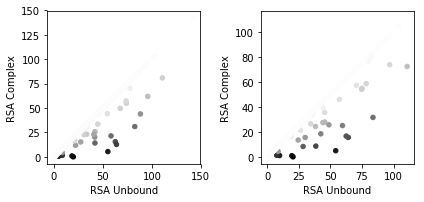

In [50]:
fig, axs = plt.subplots(1, 2, squeeze=False)

for i, (chain, chain_dssp) in enumerate(dssp_table
                                       .groupby('CHAIN')):
    chain_dssp.plot.scatter(x='RSA_UNB', y='RSA',
#                             c='delta-RSA',
                            c='rev_ratio-RSA',  # this is probably most useful
                            colorbar=False,
                            ax=axs[0, i])

for ax in axs.flat:
    ax.set_xlabel('RSA Unbound')
    ax.set_ylabel('RSA Complex')
    ax.set_aspect(1./ax.get_data_ratio())
    
plt.tight_layout()

This would be a neat way to define the interface too. I'd start by looking at the
distributions of delta-RSA and RSA-complex-free-ratio. Another time.

Let's look at the detail

In [51]:
dssp_table.query('RSA != RSA_UNB')

,RES,CHAIN,AA,SS,ACC,TCO,KAPPA,ALPHA,PHI,PSI,...,RES_UNB,SS_UNB,ACC_UNB,CHAIN_FULL_UNB,SS_CLASS_UNB,RSA_UNB,RSA_CLASS_UNB,delta-RSA,rev_ratio-RSA,ratio-RSA
0,19,A,S,,105,0.000,360.0,360.0,360.0,152.3,...,19,,144.0,A,C,110.769,Surface,30.000,0.270834,0.729166
5,24,A,Q,H,28,0.927,111.8,48.0,-58.8,-43.1,...,24,H,83.0,A,H,41.919,Surface,27.778,0.662659,0.337341
8,27,A,T,H,22,0.903,112.0,53.2,-65.9,-38.7,...,27,H,89.0,A,H,62.676,Surface,47.183,0.752808,0.247192
9,28,A,F,H,3,0.906,109.8,48.7,-59.4,-40.2,...,28,H,17.0,A,H,8.629,Part. Exposed,7.106,0.823502,0.176498
11,30,A,D,H,72,0.963,111.8,45.8,-59.8,-50.8,...,30,H,89.0,A,H,54.601,Surface,10.429,0.191004,0.808996
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1113,536,B,E,,143,0.732,48.9,68.4,-122.1,-37.1,...,536,,188.0,B,C,96.907,Surface,23.196,0.239364,0.760636
1114,537,B,G,S,43,0.217,99.8,-43.0,-76.2,-163.1,...,537,S,42.0,B,C,50.000,Surface,-1.190,-0.023800,1.023800
1115,538,B,P,,68,-0.356,59.8,-113.8,-62.4,148.4,...,538,,67.0,B,C,49.265,Surface,-0.735,-0.014919,1.014919
1119,542,B,f,,1,-0.684,38.2,179.2,-90.2,130.8,...,542,,1.0,B,C,0.741,Core,NaN,NaN,NaN


Let's annotate the ACE2 interface residues

In [52]:
dssp_mvps = ['RES', 'SS', 'RSA', 'RSA_UNB', 'RSA_CLASS', 'RSA_CLASS_UNB',
             'delta-RSA', 'ratio-RSA']
ace2_dssp = dssp_table.query('CHAIN == "A"')[dssp_mvps]
ace2_dssp

,RES,SS,RSA,RSA_UNB,RSA_CLASS,RSA_CLASS_UNB,delta-RSA,ratio-RSA
0,19,,80.769,110.769,Surface,Surface,30.0,0.729166
1,20,,54.930,54.930,Surface,Surface,0.0,1.000000
2,21,H,25.444,25.444,Surface,Surface,0.0,1.000000
3,22,H,13.402,13.402,Part. Exposed,Part. Exposed,0.0,1.000000
4,23,H,50.000,50.000,Surface,Surface,0.0,1.000000
...,...,...,...,...,...,...,...,...
591,610,,32.159,32.159,Surface,Surface,0.0,1.000000
592,611,,19.231,19.231,Part. Exposed,Part. Exposed,0.0,1.000000
593,612,S,27.941,27.941,Surface,Surface,0.0,1.000000
594,613,,33.784,33.784,Surface,Surface,0.0,1.000000


Here's a pretty version for reports.

TODO: Need residue labels

In [53]:
ace2_interface_report = ace2_interface.copy()
ace2_interface_report = pd.merge(ace2_interface, ace2_dssp, left_on='resnum', right_on='RES',
                                 how='left')

# # Fingerprint representation of ARPEGGIO interaction type
# # This probably uses less ink but I think it actually makes the table wider
# obsereved_int_types = list({e for _set in ace2_interface_report['int_types'].values for e in _set})
# obsereved_int_types.sort()
# _fingerprint = pd.concat([ace2_interface_report['int_types'].apply(lambda l: s in l)
#                           for s in obsereved_int_types],
#                          axis=1, keys=obsereved_int_types)
# _fingerprint = _fingerprint.astype(int)
# ace2_interface_report = pd.concat([ace2_interface_report, _fingerprint], axis=1)

# # Can make a "fingerprint" of  S-protein partner residues too
# # This is cool and potentially useful for certain comparisons (e.g. clustering)
# # but its too wide, so commenting out
# obsereved_contacts = list({e for _set in ace2_interface_report['contacts'].values for e in _set})
# obsereved_contacts.sort()
# _fingerprint = pd.concat([ace2_interface_report['contacts'].apply(lambda l: s in l)
#                           for s in obsereved_contacts],
#                          axis=1, keys=obsereved_contacts)
# _fingerprint = _fingerprint.astype(int)
# ace2_interface_report = pd.concat([ace2_interface_report, _fingerprint], axis=1)


# # Don't actually need the index because resnum is there too
# ace2_interface_report.index.name = 'Residue'
# ace2_interface_report.index = ace2_interface_report.index.str.replace('ACE2', '')

ace2_interface_report['int_types'] = (ace2_interface_report['int_types']
                                      .apply(lambda _set: {e.replace('Weak-', '') for e in _set})
                                      .apply(lambda _set: {e for e in _set if e != 'VDW-Proximal'}
                                             if len(_set) > 1 else _set)
#                                       .apply(lambda _set: _set.discard('VDW-Proximal'))
                                      .apply(lambda l: sorted(list(l)))
                                      .astype(str)
                                      .str.replace('[\[\]\']', '')
                                      .str.replace('Hydrogen', 'H')
#                                       .str.replace('Polar-Bond', 'Polar')
                                      .str.replace('VDW-Clash', 'Clash')
                                      .str.replace('VDW', 'VdW')
#                                       .str.replace('(Weak-)(.*)', '\\2 (weak)')
#                                       .str.replace('Weak-', '')
                                     )
ace2_interface_report['contacts'] = ace2_interface_report['contacts'].apply(lambda x: sorted(list(x)))
ace2_interface_report['contacts'] = ace2_interface_report['contacts'].astype(str).str.replace('nCoV|[\[\]\']', '')
for three, one in prointvar.library.aa_codes_3to1_common.items():
    ace2_interface_report['contacts'] = ace2_interface_report['contacts'].str.replace(three, one)
# compact resnames
ace2_interface_report['resname'] = ace2_interface_report['resname'].map(prointvar.library.aa_codes_3to1_common)
ace2_interface_report['ACE2 Residue'] = ace2_interface_report['resname'] + ace2_interface_report['resnum']
# pretty column names
ace2_interface_report = ace2_interface_report.rename(columns={'int_types': 'ARPEGGIO Interaction Types',
                                                              'min_vdw_dist': 'Min. VdW Distance',
                                                              'interface_cn': 'Interface Contact Number',
                                                              'contacts': 'S-protein counterparts',
#                                                               'resnum': 'ACE2 Residue',
                                                              'RSA': 'RSA Complex',
                                                              'RSA_UNB': 'RSA Free',
                                                              'RSA_CLASS': 'RSA Class Complex',
                                                              'RSA_CLASS_UNB': 'RSA Class Free'})
# Order
ace2_interface_report['resnum'] = ace2_interface_report['resnum'].astype(int)
ace2_interface_report = ace2_interface_report.sort_values('resnum')
ace2_interface_report = ace2_interface_report[['ACE2 Residue', 'Interface Contact Number', 'Min. VdW Distance',
                                               'S-protein counterparts', 'ARPEGGIO Interaction Types',
                                               'RSA Class Free', 'RSA Class Complex', 'delta-RSA',
                                               'ratio-RSA']]
ace2_interface_report = ace2_interface_report.reset_index(drop=True)
ace2_interface_report.to_csv('notebook_output/ACE2-Spike-interface-residues.csv', index=False)
ace2_interface_report

,ACE2 Residue,Interface Contact Number,Min. VdW Distance,S-protein counterparts,ARPEGGIO Interaction Types,RSA Class Free,RSA Class Complex,delta-RSA,ratio-RSA
0,S19,3,0.000,"A475, G476, S477","Polar-Bond, VdW-Bond, Clash",Surface,Surface,30.000,0.729166
1,Q24,6,0.000,"A475, N487, G476, F486, S477, Y489","H-Bond, Clash",Surface,Part. Exposed,27.778,0.337341
2,T27,5,0.401,"A475, N487, F456, Y473, Y489",VdW-Proximal,Surface,Part. Exposed,47.183,0.247192
3,F28,1,0.156,Y489,"H-Bond, Polar-Bond",Part. Exposed,Core,7.106,0.176498
4,D30,2,0.716,"L455, F456",Hydrophobic-Bond,Surface,Surface,10.429,0.808996
5,K31,6,0.000,"Q493, L455, L492, F456, F490, Y489","Hydrophobic-Bond, Clash",Surface,Part. Exposed,51.219,0.198476
6,H34,3,0.000,"Q493, L455, Y453","Aromatic-Bond, H-Bond, Hydrophobic-Bond, Polar...",Surface,Surface,51.631,0.374995
7,E35,1,0.000,Q493,"H-Bond, Polar-Bond, Clash",Surface,Surface,11.340,0.747129
8,E37,1,0.145,Y505,"H-Bond, Hydrophobic-Bond, Polar-Bond",Part. Exposed,Part. Exposed,10.309,0.534897
9,D38,4,0.000,"Q498, G496, HOH701, Y449","H-Bond, Polar-Bond, VdW-Bond, Clash",Surface,Part. Exposed,21.473,0.485282


Again, assumes that chain A/B numbering is equivalent...

In [54]:
pdb_x_uniprot = (sifts_table
                 .query('UniProt_dbAccessionId == "Q9BYF1" & PDB_dbChainId == "A"')
                 [['PDB_dbResNum', 'UniProt_dbResNum']]
                )
ace2_interface_mapped = pd.merge(ace2_interface, pdb_x_uniprot, left_on='resnum', right_on='PDB_dbResNum')

In [55]:
ace2_interface_mapped.loc[:, 'UniProt_dbResNum'] = ace2_interface_mapped['UniProt_dbResNum'].astype(int)
ace2_interface_variants = pd.merge(aln_variants.loc['ACE2_HUMAN/1-805', mvps], ace2_interface_mapped,
                                   left_index=True, right_on='UniProt_dbResNum')
ace2_interface_variants.dropna(subset=[('VEP', 'HGVSp')])

2020-04-28 01:18:37,275 py.warnings  WARNING  /Users/smacgowan/miniconda3/envs/varalign-nCoV/lib/python3.6/site-packages/pandas/core/reshape/merge.py:618: UserWarning: merging between different levels can give an unintended result (2 levels on the left, 1 on the right)
  warnings.warn(msg, UserWarning)



,"(Row, ID)","(Row, FILTER)","(VEP, HGVSp)","(Site_INFO, AN)","(Allele_INFO, AC)","(Allele_INFO, Hom)","(Allele_INFO, AC_Male)","(Allele_INFO, Hemi)","(Allele_INFO, POPMAX)","(Allele_INFO, AC_POPMAX)",int_types,min_vdw_dist,interface_cn,contacts,resname,resnum,PDB_dbResNum,UniProt_dbResNum
20,rs73635825,[],ENSP00000389326.1:p.Ser19Pro,178042.0,40.0,0.0,6.0,6.0,AFR,39.0,"{Weak-Polar-Bond, VDW-Proximal, VDW-Clash, Pol...",0.000,3,"{nCoVGLY476, nCoVSER477, nCoVALA475}",SER,19,19,19
21,rs781255386,[],ENSP00000389326.1:p.Thr27Ala,178629.0,2.0,0.0,0.0,0.0,AMR,2.0,{VDW-Proximal},0.401,5,"{nCoVTYR473, nCoVALA475, nCoVASN487, nCoVPHE45...",THR,27,27,27
16,rs758278442,[],ENST00000427411.1:c.93G>A(p.%3D),178667.0,3.0,0.0,1.0,1.0,EAS,3.0,"{Hydrophobic-Bond, VDW-Proximal, VDW-Clash}",0.000,6,"{nCoVTYR489, nCoVLEU455, nCoVLEU492, nCoVGLN49...",LYS,31,31,31
13,rs368655410,[],ENST00000427411.1:c.102C>T(p.%3D),178668.0,111.0,0.0,39.0,39.0,FIN,52.0,"{Hydrogen-Bond, Hydrophobic-Bond, VDW-Proximal...",0.000,3,"{nCoVGLN493, nCoVTYR453, nCoVLEU455}",HIS,34,34,34
10,None,[],ENSP00000389326.1:p.Glu35Lys,178681.0,3.0,0.0,1.0,1.0,EAS,2.0,"{Hydrogen-Bond, VDW-Proximal, VDW-Clash, Polar...",0.000,1,{nCoVGLN493},GLU,35,35,35
11,rs146676783,[],ENSP00000389326.1:p.Glu37Lys,178649.0,6.0,0.0,3.0,3.0,FIN,5.0,"{Hydrogen-Bond, Hydrophobic-Bond, VDW-Proximal...",0.145,1,{nCoVTYR505},GLU,37,37,37
18,rs766996587,[],ENSP00000389326.1:p.Met82Ile,178068.0,0.0,0.0,0.0,0.0,None,NaN,"{Hydrophobic-Bond, VDW-Proximal, VDW-Bond}",0.081,1,{nCoVPHE486},MET,82,82,82
18,rs766996587,[],ENSP00000389326.1:p.Met82Ile,178068.0,2.0,0.0,0.0,0.0,AFR,2.0,"{Hydrophobic-Bond, VDW-Proximal, VDW-Bond}",0.081,1,{nCoVPHE486},MET,82,82,82
9,rs143936283,[],ENSP00000389326.1:p.Glu329Gly,176748.0,5.0,0.0,0.0,0.0,NFE,4.0,{VDW-Proximal},0.986,1,{nCoVARG439},GLU,329,329,329
4,None,[],ENSP00000389326.1:p.Asp355Asn,165871.0,2.0,0.0,0.0,0.0,NFE,2.0,{VDW-Proximal},0.195,2,"{nCoVTHR500, nCoVGLY502}",ASP,355,355,355


TODO: Contact should include residue pair

Write out variants for report.

In [56]:
ace2_interface_variants_report = my.variant_report_table(ace2_interface_variants,
                                                         'notebook_output/ACE2-Spike-interface-variants.csv')
ace2_interface_variants_report

,ID,Mutation,Allele Count,AC Male,AC Popn. Max,Popn. Max
20,rs73635825,p.Ser19Pro,40,6,39,AFR
21,rs781255386,p.Thr27Ala,2,0,2,AMR
16,rs758278442,c.93G>A(p.%3D),3,1,3,EAS
13,rs368655410,c.102C>T(p.%3D),111,39,52,FIN
10,-,p.Glu35Lys,3,1,2,EAS
11,rs146676783,p.Glu37Lys,6,3,5,FIN
18,rs766996587,p.Met82Ile,0,0,0,None
18,rs766996587,p.Met82Ile,2,0,2,AFR
9,rs143936283,p.Glu329Gly,5,0,4,NFE
4,-,p.Asp355Asn,2,0,2,NFE


## "Extended interface"

Note:
- I need to consider residues not on the interface but close to it too. These could have
  indirect steric effects. Indeed, some assays indicate binding effects of non-interface
  residues.
  
Options:
- Relaxed distance metric
- 2nd degree contacts - sounds good but might miss obvious residues (e.g., if arpeggio
- ignores adjacent residues; easy fix for this or ruled out because of side-chain
  orientation)

# mCSM-PPI2 and MutaBind2

## Input files for the web server

Mutation list for mCSM-PPI2.

n.b. Consider submitting both the AU and biological units to the server.

In [57]:
mutation_list = (ace2_interface_variants
                 .set_index(('VEP', 'HGVSp'), drop=False)  # so I can `filter`
                 [('VEP', 'HGVSp')]
                 .dropna()
                 .str.split(':p.').str[-1]
                 .str.upper()
                 .filter(regex='p.[A-Z][a-z]{2}')
                 .drop_duplicates()  # p.Met82Ile, guess two degenerate missense
                )
# Convert 3-letter to 1-letter codes
for three, one in prointvar.library.aa_codes_3to1_common.items():
    mutation_list = mutation_list.str.replace(three, one)
# Prepend chain A ID and write out
('A ' + mutation_list).to_csv('mCSM-PPI2-Predictions/submission-lists/gnomAD-6vw1-interface-input.txt',
                              header=False, index=False)
! cat mCSM-PPI2-Predictions/submission-lists/gnomAD-6vw1-interface-input.txt

A S19P
A T27A
A E35K
A E37K
A M82I
A E329G
A D355N


And for MutaBind2

In [58]:
mutabind_input = mutation_list.to_frame()
mutabind_input['formatted'] = mutation_list.str[:-1]
mutabind_input['mut'] = mutation_list.str[-1]
mutabind_input['chain'] = 'A'
mutabind_input = mutabind_input.set_index('formatted', drop=False)
(mutabind_input[['chain', 'formatted', 'mut']]
 .to_csv('MutaBind2/6vw1-gnomad-interface-input.txt', header=False, index=False, sep='\t')
)
! cat MutaBind2/6vw1-gnomad-interface-input.txt

A	S19	P
A	T27	A
A	E35	K
A	E37	K
A	M82	I
A	E329	G
A	D355	N


I should submit all the variants that map to the structure for prediction to be
comprehensive.

In [59]:
res_in_pdb = pdb_x_uniprot.loc[pdb_x_uniprot['PDB_dbResNum'] == pdb_x_uniprot['UniProt_dbResNum'],
                               'UniProt_dbResNum']
mutation_list = (aln_variants
                 .loc['ACE2_HUMAN/1-805']
                 .loc[res_in_pdb.astype(int)]
                 .set_index(('VEP', 'HGVSp'), drop=False)  # so I can `filter`
                 [('VEP', 'HGVSp')]
                 .dropna()
                 .str.split(':p.').str[-1]
                 .str.upper()
                 .filter(regex='p.[A-Z][a-z]{2}[0-9]+[A-Z][a-z]{2}$')
                 .filter(regex='^((?!Ter).)*$')
                 .drop_duplicates()  # p.Met82Ile, guess two degenerate missense
                )
# Convert 3-letter to 1-letter codes
for three, one in prointvar.library.aa_codes_3to1_common.items():
    mutation_list = mutation_list.str.replace(three, one)
# Prepend chain A ID and write out
('A ' + mutation_list).to_csv('mCSM-PPI2-Predictions/submission-lists/gnomAD-6vw1-input.txt', header=False, index=False)
! head -1 mCSM-PPI2-Predictions/submission-lists/gnomAD-6vw1-input.txt

A S19P


And for MutaBind2

In [60]:
mutabind_input = mutation_list.to_frame()
mutabind_input['formatted'] = mutation_list.str[:-1]
mutabind_input['mut'] = mutation_list.str[-1]
mutabind_input['chain'] = 'A'
mutabind_input = mutabind_input.set_index('formatted', drop=False)
(mutabind_input[['chain', 'formatted', 'mut']]
 .to_csv('MutaBind2/6vw1-gnomad-input.txt', header=False, index=False, sep='\t')
)
! head -1 MutaBind2/6vw1-gnomad-input.txt

A	S19	P


Here's all the assay mutants for validation.

In [61]:
input_assay_mutants = mutants.loc[:, ['START', 'effect', 'mutant']]
input_assay_mutants[['wt', 'mut']] = mutants['mutant'].str.split('->', expand=True)
input_assay_mutants['formatted'] = input_assay_mutants[['wt', 'START', 'mut']].astype(str).sum(axis=1)
input_assay_mutants = input_assay_mutants.set_index('formatted', drop=False)
('A ' + input_assay_mutants['formatted'].filter(regex='[A-Z][0-9]+[A-Z]$')).to_csv('6vw1-mutagenesis-input.txt',
                                                                                   header=False, index=False)
! head -1 6vw1-mutagenesis-input.txt

A K31D


Here's MutaBind2 input format

In [62]:
mutabind_input = mutants.loc[:, ['START', 'effect', 'mutant']]
mutabind_input[['wt', 'mut']] = mutants['mutant'].str.split('->', expand=True)
mutabind_input['formatted'] = mutabind_input[['wt', 'START']].astype(str).sum(axis=1)
mutabind_input['chain'] = 'A'
mutabind_input = mutabind_input.set_index('formatted', drop=False)
(mutabind_input[['chain', 'formatted', 'mut']]
 .filter(regex='^[A-Z][0-9]+', axis=0)
 .to_csv('MutaBind2/6vw1-mutagenesis-input.txt', header=False, index=False, sep='\t')
)
! head -1 MutaBind2/6vw1-mutagenesis-input.txt

A	K31	D


There are a few mutants I found in the paper that are missing from my UniProt annotations.

In [63]:
supplementary_mutants = [
    'A P84S\n',
#     'A Q306E\n',  # mCSM-PPI2 complains that this is the wrong residue for 2ajf
    'A K309A\n'
]

with open('6vw1-mutagenesis-input-supplement.txt', 'w') as output:
    output.writelines(supplementary_mutants)
    
! cat 6vw1-mutagenesis-input-supplement.txt

A P84S
A K309A


Note:
- for simplicity I've started with the single-points. Later, I could try the double and
  triple mutants. Perhaps by spliting them into single-point series though this would
  be entirely equivalent.

## ddG Prediction Data

The mutagenesis assay set.

In [64]:

paths = [
#     'mCSM-PPI2-Predictions/6vw1-ACE2-nCoV_S-mutagenesis.csv',
    'mCSM-PPI2-Predictions/2ajf/jobs/binding-assay-mutants-additional/2ajf-ACE2-mutagenesis-suplementary.csv',  
    'mCSM-PPI2-Predictions/2ajf/jobs/binding-assay-mutants/2ajf-ACE2-nCoV_S-mutagenesis.csv'
]

ddG_mutant_assays = []
for path in paths:
    ddG_mutant_assays.append(pd.read_csv(path))

ddG_mutant_assays = pd.concat(ddG_mutant_assays, axis=0, ignore_index=True)


# prepare merge key
ddG_mutant_assays['formatted'] = (ddG_mutant_assays
                                  [['wild-type', 'res-number', 'mutant']]
                                  .astype(str)
                                  .sum(axis=1)
                                 )
# Convert 3-letter to 1-letter codes
for three, one in prointvar.library.aa_codes_3to1_common.items():
    ddG_mutant_assays['formatted'] = ddG_mutant_assays['formatted'].str.replace(three, one)
# Merge with
ddG_mutant_assays = pd.merge(ddG_mutant_assays,
                             input_assay_mutants.reset_index(drop=True),
                             on='formatted', how='outer')
ddG_mutant_assays.sort_values('mcsm-ppi2-prediction')

,chain,wild-type,res-number,mutant_x,distance-to-interface,mcsm-ppi2-prediction,affinity,formatted,START,effect,mutant_y,wt,mut
14,A,LYS,353.0,ASP,2.549,-1.917,Decreasing,K353D,353,Abolishes interaction with SARS-CoV spike glyc...,K->D,K,D
22,A,ASP,355.0,ALA,3.594,-1.802,Decreasing,D355A,355,Strongly inhibits interaction with SARS-CoV sp...,D->A,D,A
8,A,LYS,353.0,ALA,2.549,-1.567,Decreasing,K353A,353,Abolishes interaction with SARS-CoV spike glyc...,K->A,K,A
11,A,TYR,41.0,ALA,2.828,-1.500,Decreasing,Y41A,41,Strongly inhibits interaction with SARS-CoV sp...,Y->A,Y,A
7,A,ARG,357.0,ALA,3.614,-1.170,Decreasing,R357A,357,Strongly inhibits interaction with SARS-CoV sp...,R->A,R,A
4,A,GLU,37.0,ALA,3.369,-0.730,Decreasing,E37A,37,No effect on interaction with SARS-CoV spike g...,E->A,E,A
19,A,ASP,38.0,ALA,3.016,-0.633,Decreasing,D38A,38,No effect on interaction with SARS-CoV spike g...,D->A,D,A
23,A,LYS,31.0,ASP,3.569,-0.251,Decreasing,K31D,31,Abolishes interaction with SARS-CoV spike glyc...,K->D,K,D
26,A,ARG,393.0,ALA,4.410,-0.239,Decreasing,R393A,393,Slightly inhibits interaction with SARS-CoV sp...,R->A,R,A
6,A,LEU,359.0,ALA,13.566,-0.238,Decreasing,L359A,359,No effect on interaction with SARS-CoV spike g...,L->A,L,A


In [65]:
ddG_mutant_assays['mcsm-ppi2-prediction-binned'] = pd.cut(ddG_mutant_assays['mcsm-ppi2-prediction'], 4)
pd.crosstab(ddG_mutant_assays['mcsm-ppi2-prediction-binned'],
            ddG_mutant_assays['effect'])
            

effect,Abolishes interaction with SARS-CoV spike glycoprotein,Does not affect amino acid transport activity of SLC6A19,No effect on interaction with SARS-CoV spike glycoprotein,Slightly inhibits interaction with SARS-CoV spike glycoprotein,Strongly inhibits interaction with SARS-CoV spike glycoprotein
mcsm-ppi2-prediction-binned,,,,,
"(-1.919, -1.402]",2,0,0,0,2
"(-1.402, -0.886]",0,0,0,0,1
"(-0.886, -0.37]",0,0,2,0,0
"(-0.37, 0.145]",2,1,12,5,0


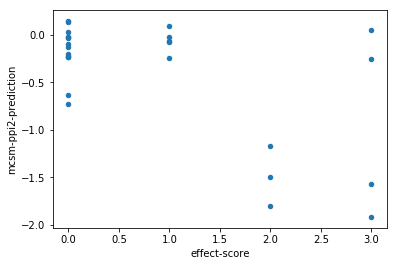

In [66]:
effect_score_map = {'Abolishes interaction with SARS-CoV spike glycoprotein': 3,
                    'Strongly inhibits interaction with SARS-CoV spike glycoprotein': 2,
                    'Slightly inhibits interaction with SARS-CoV spike glycoprotein': 1,
                    'No effect on interaction with SARS-CoV spike glycoprotein': 0
                   }
ddG_mutant_assays['effect-score'] = ddG_mutant_assays['effect'].map(effect_score_map)
ddG_mutant_assays.plot.scatter(x='effect-score', y='mcsm-ppi2-prediction')

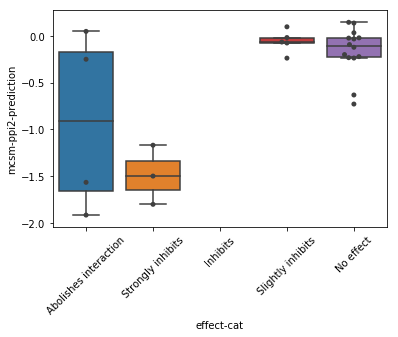

In [67]:
ddG_mutant_assays['effect-cat'] = my.categorise_mutagenesis_assays(ddG_mutant_assays['effect'])
# ddG_mutant_assays.plot.scatter(x='effect-cat', y='mcsm-ppi2-prediction')
# ddG_mutant_assays.boxplot(by='effect-cat', column='mcsm-ppi2-prediction', rot=45)

# sns.set(style="whitegrid")
ax = sns.boxplot(x="effect-cat", y="mcsm-ppi2-prediction", data=ddG_mutant_assays,
                 showfliers = False)
ax = sns.swarmplot(x="effect-cat", y="mcsm-ppi2-prediction", data=ddG_mutant_assays,
                   color=".25")
_ = ax.set_xticklabels(ax.get_xticklabels(), rotation=45)

Use extracted S1-Ig-associations. Not all the mutants have a score (yet). Also veryfy UniProt annotations.

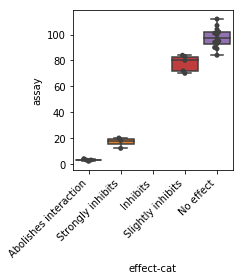

In [68]:
paths = [
    'mutagenesis-assays/mutant-S1-Ig-association-from-Fig3.csv',  
    'mutagenesis-assays/mutant-S1-Ig-association-from-Fig1-singles.csv'
]

mutant_assocation_pct = []
for path in paths:
    mutant_assocation_pct.append(pd.read_csv(path, header=None, names=['mutant', 'assay']))

mutant_assocation_pct = pd.concat(mutant_assocation_pct, axis=0, ignore_index=True)
    

ddG_mutant_assays = pd.merge(ddG_mutant_assays, mutant_assocation_pct,
                             left_on='formatted', right_on='mutant',
                             how='outer'
                            )

fig, axs = plt.subplots(squeeze=False)
ax = sns.boxplot(x="effect-cat", y="assay", data=ddG_mutant_assays,
                 showfliers = False, ax=axs[0, 0])
ax = sns.swarmplot(x="effect-cat", y="assay", data=ddG_mutant_assays,
                   color=".25", ax=axs[0, 0])
_ = ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')

for ax in axs.flat:
    ax.set_aspect(1./ax.get_data_ratio())
    
plt.tight_layout()
    
plt.savefig('notebook_output/mutagenesis-transcribed-vs-description.png')
plt.savefig('notebook_output/mutagenesis-transcribed-vs-description.svg')

In [69]:
ddG_mutant_assays

,chain,wild-type,res-number,mutant_x,distance-to-interface,mcsm-ppi2-prediction,affinity,formatted,START,effect,mutant_y,wt,mut,mcsm-ppi2-prediction-binned,effect-score,effect-cat,mutant,assay
0,A,PRO,84.0,SER,9.018,-0.084,Decreasing,P84S,NaN,NaN,NaN,NaN,NaN,"(-0.37, 0.145]",NaN,NaN,P84S,82.0
1,A,LYS,309.0,ALA,13.071,-0.059,Decreasing,K309A,NaN,NaN,NaN,NaN,NaN,"(-0.37, 0.145]",NaN,NaN,K309A,100.0
2,A,LYS,309.0,ASP,13.071,-0.034,Decreasing,K309D,309,No effect on interaction with SARS-CoV spike g...,K->D,K,D,"(-0.37, 0.145]",0.0,No effect,NaN,NaN
3,A,HIS,239.0,GLN,50.038,0.032,Increasing,H239Q,239,No effect on interaction with SARS-CoV spike g...,H->Q,H,Q,"(-0.37, 0.145]",0.0,No effect,H239Q,102.0
4,A,GLU,37.0,ALA,3.369,-0.730,Decreasing,E37A,37,No effect on interaction with SARS-CoV spike g...,E->A,E,A,"(-0.886, -0.37]",0.0,No effect,E37A,94.0
5,A,ARG,219.0,ASP,26.548,-0.025,Decreasing,R219D,219,No effect on interaction with SARS-CoV spike g...,R->D,R,D,"(-0.37, 0.145]",0.0,No effect,R219D,84.0
6,A,LEU,359.0,ALA,13.566,-0.238,Decreasing,L359A,359,No effect on interaction with SARS-CoV spike g...,L->A,L,A,"(-0.37, 0.145]",0.0,No effect,L359A,104.0
7,A,ARG,357.0,ALA,3.614,-1.170,Decreasing,R357A,357,Strongly inhibits interaction with SARS-CoV sp...,R->A,R,A,"(-1.402, -0.886]",2.0,Strongly inhibits,R357A,18.0
8,A,LYS,353.0,ALA,2.549,-1.567,Decreasing,K353A,353,Abolishes interaction with SARS-CoV spike glyc...,K->A,K,A,"(-1.919, -1.402]",3.0,Abolishes interaction,K353A,4.0
9,A,LYS,353.0,HIS,2.549,0.047,Increasing,K353H,353,Abolishes interaction with SARS-CoV spike glyc...,K->H,K,H,"(-0.37, 0.145]",3.0,Abolishes interaction,K353H,3.0


TODO: See if there are any missing values I can fill.

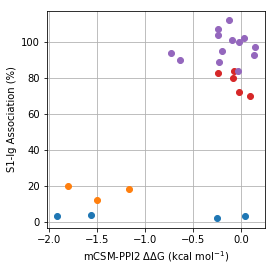

In [70]:
fig, axs = plt.subplots(squeeze=False)

for name, group in ddG_mutant_assays.groupby('effect-cat'):
    axs[0, 0].plot(group['mcsm-ppi2-prediction'], group['assay'], marker='o',
                   linestyle='', ms=6, label=name)
    
axs[0, 0].set_xlabel('mCSM-PPI2 ΔΔG (kcal mol$^{-1}$)')
axs[0, 0].set_ylabel('S1-Ig Association (%)')
# axs[0, 0].set_yscale('log')  # maybey useful since the assay yields a ratio

for ax in axs.flat:
    ax.set_aspect(1./ax.get_data_ratio())
    ax.grid()
    
# _ = axs[0, 0].legend(loc='upper left')
plt.savefig('notebook_output/plot-mutagenesis-assay-vs-prediction.svg')
plt.savefig('notebook_output/plot-mutagenesis-assay-vs-prediction.png')

In [71]:
(stats.pearsonr(*ddG_mutant_assays[['assay', 'mcsm-ppi2-prediction']].dropna().values.T),
stats.spearmanr(*ddG_mutant_assays[['assay', 'mcsm-ppi2-prediction']].dropna().values.T)
)

((0.6805682816556062, 9.36714071442142e-05),
 SpearmanrResult(correlation=0.31730038449014025, pvalue=0.10680657732477641))

In [72]:
ddG_mutant_assays.groupby('effect-cat')['mcsm-ppi2-prediction'].describe()

,count,mean,std,min,25%,50%,75%,max
effect-cat,,,,,,,,
Abolishes interaction,4.0,-0.922000,0.965272,-1.917,-1.65450,-0.9090,-0.17650,0.047
Strongly inhibits,3.0,-1.490667,0.316103,-1.802,-1.65100,-1.5000,-1.33500,-1.170
Inhibits,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Slightly inhibits,5.0,-0.061200,0.120819,-0.239,-0.07700,-0.0670,-0.01900,0.096
No effect,14.0,-0.160357,0.254438,-0.730,-0.23125,-0.1085,-0.02275,0.144


In [73]:
pd.crosstab(ddG_mutant_assays['mcsm-ppi2-prediction'] < -1.0,
            ddG_mutant_assays['effect-cat'])

effect-cat,Abolishes interaction,Strongly inhibits,Inhibits,Slightly inhibits,No effect
mcsm-ppi2-prediction,,,,,
False,2,0,1,7,17
True,2,3,0,0,0


In [74]:
# Simple confusion matrix
pd.crosstab(ddG_mutant_assays['mcsm-ppi2-prediction'] < -1.0,
            ddG_mutant_assays['effect-cat'] <= 'Strongly inhibits')

effect-cat,False,True
mcsm-ppi2-prediction,,
False,30,2
True,0,5


What are the confused mutants?

In [75]:
ddG_mutant_assays.query('`effect-cat` == "Abolishes interaction"')

,chain,wild-type,res-number,mutant_x,distance-to-interface,mcsm-ppi2-prediction,affinity,formatted,START,effect,mutant_y,wt,mut,mcsm-ppi2-prediction-binned,effect-score,effect-cat,mutant,assay
8,A,LYS,353.0,ALA,2.549,-1.567,Decreasing,K353A,353,Abolishes interaction with SARS-CoV spike glyc...,K->A,K,A,"(-1.919, -1.402]",3.0,Abolishes interaction,K353A,4.0
9,A,LYS,353.0,HIS,2.549,0.047,Increasing,K353H,353,Abolishes interaction with SARS-CoV spike glyc...,K->H,K,H,"(-0.37, 0.145]",3.0,Abolishes interaction,K353H,3.0
14,A,LYS,353.0,ASP,2.549,-1.917,Decreasing,K353D,353,Abolishes interaction with SARS-CoV spike glyc...,K->D,K,D,"(-1.919, -1.402]",3.0,Abolishes interaction,K353D,3.0
23,A,LYS,31.0,ASP,3.569,-0.251,Decreasing,K31D,31,Abolishes interaction with SARS-CoV spike glyc...,K->D,K,D,"(-0.37, 0.145]",3.0,Abolishes interaction,K31D,2.0


TODO:
- Inspect any misclassifications on the mCSM-PPI2 web server (two false positives)

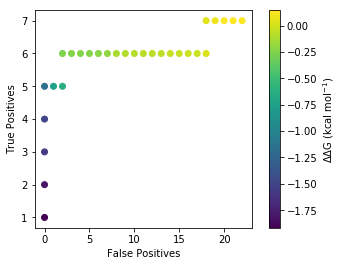

In [76]:
ddG_mutant_assays = ddG_mutant_assays.sort_values('mcsm-ppi2-prediction')
ddG_mutant_assays['assay_positive'] = ddG_mutant_assays['effect-cat'] <= 'Strongly inhibits'

fig, axs = plt.subplots(squeeze=False)
sc = axs[0, 0].scatter(y=ddG_mutant_assays['assay_positive'].cumsum(),
                  x=(~ddG_mutant_assays['assay_positive']).cumsum(),
                  c=ddG_mutant_assays['mcsm-ppi2-prediction']
                 )

axs[0, 0].set_xlabel('False Positives')
axs[0, 0].set_ylabel('True Positives')
cb = plt.colorbar(sc)
cb.set_label('ΔΔG (kcal mol$^{-1}$)')

for ax in axs.flat:
    ax.set_aspect(1./ax.get_data_ratio())
    
plt.savefig('notebook_output/mCSM-PPI2-Prediction-vs-assayed-ROC.svg')
plt.savefig('notebook_output/mCSM-PPI2-Prediction-vs-assayed-ROC.png')

I have seen sites where some mutants are predicted to decrease binding and
others predicted to have no effect (e.g., K353). Are there any sites with
experimentally observed mutants that display srheostatic as opposed to toggle
behaviour?

In [77]:
ddG_mutant_assays.groupby(['res-number', 'effect-cat'], observed=True).size()

res-number  effect-cat           
31.0        Abolishes interaction    1
37.0        No effect                1
38.0        No effect                1
41.0        Strongly inhibits        1
68.0        Slightly inhibits        1
110.0       No effect                1
160.0       No effect                1
192.0       No effect                1
219.0       No effect                1
239.0       No effect                1
309.0       No effect                1
312.0       No effect                1
324.0       No effect                1
350.0       No effect                1
353.0       Abolishes interaction    3
355.0       Strongly inhibits        1
357.0       Strongly inhibits        1
359.0       No effect                2
383.0       Slightly inhibits        1
389.0       Slightly inhibits        1
393.0       Slightly inhibits        1
559.0       Slightly inhibits        1
603.0       No effect                1
dtype: int64

n.b. leaving out double and triple mutants for now.

There are very few sites with multiple mutants anyway.

### Reverse mutants

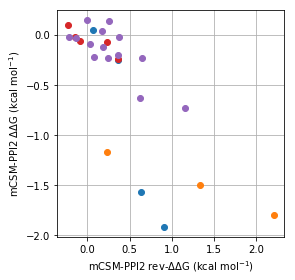

In [78]:
ddG_validation_reverse = my.read_mCSM_table('mCSM-PPI2-Predictions/2ajf-reverse-mutations/transcribed-predictions.csv')
ddG_validation_reverse = ddG_validation_reverse.rename(columns={'mutant': 'wild-type', 'wild-type': 'mutant'})
ddG_validation_reverse = pd.merge(ddG_validation_reverse, ddG_mutant_assays,
                                  left_on=('mutant', 'wild-type', 'res-number'),
                                  right_on=('mutant_x', 'wild-type', 'res-number'),
                                  suffixes=('_reverse', '')
                                 )

fig, ax = plt.subplots(1, 1)

for name, group in ddG_validation_reverse.groupby('effect-cat'):
    ax.plot(group['mcsm-ppi2-prediction_reverse'], group['mcsm-ppi2-prediction'], marker='o',
            linestyle='', ms=6, label=name)

ax.set_xlabel('mCSM-PPI2 rev-ΔΔG (kcal mol$^{-1}$)')
ax.set_ylabel('mCSM-PPI2 ΔΔG (kcal mol$^{-1}$)')
    
ax.set_aspect(1./ax.get_data_ratio())
ax.grid()

plt.tight_layout()

plt.savefig('notebook_output/plot-ddG-vs-rev-ddG.svg')
plt.savefig('notebook_output/plot-ddG-vs-rev-ddG.png')

In [79]:
(stats.pearsonr(*ddG_validation_reverse[['mcsm-ppi2-prediction', 'mcsm-ppi2-prediction_reverse']].dropna().values.T),
stats.spearmanr(*ddG_validation_reverse[['mcsm-ppi2-prediction', 'mcsm-ppi2-prediction_reverse']].dropna().values.T)
)

((-0.779677363696675, 1.6381774280197377e-06),
 SpearmanrResult(correlation=-0.7190840029874259, pvalue=2.3784353897801233e-05))

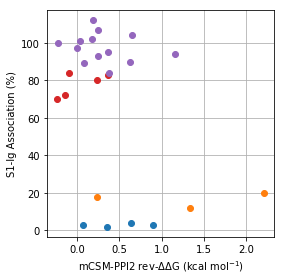

In [80]:
fig, ax = plt.subplots()

for name, group in ddG_validation_reverse.groupby('effect-cat'):
    ax.plot(group['mcsm-ppi2-prediction_reverse'], group['assay'], marker='o',
            linestyle='', ms=6, label=name)
    
ax.set_xlabel('mCSM-PPI2 rev-ΔΔG (kcal mol$^{-1}$)')
ax.set_ylabel('S1-Ig Association (%)')

ax.set_aspect(1./ax.get_data_ratio())
ax.grid()

plt.tight_layout()

plt.savefig('notebook_output/plot-assay-vs-rev-ddG.svg')
plt.savefig('notebook_output/plot-assay-vs-rev-ddG.png')

In [81]:
(stats.pearsonr(*ddG_validation_reverse[['assay', 'mcsm-ppi2-prediction_reverse']].dropna().values.T),
stats.spearmanr(*ddG_validation_reverse[['assay', 'mcsm-ppi2-prediction_reverse']].dropna().values.T)
)

((-0.40930400201956807, 0.042179997459373786),
 SpearmanrResult(correlation=-0.21093148575827558, pvalue=0.3114860506302238))

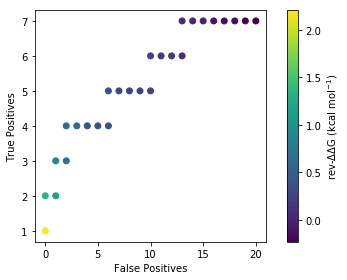

In [82]:
ddG_validation_reverse = ddG_validation_reverse.sort_values('mcsm-ppi2-prediction_reverse', ascending=False)
ddG_validation_reverse['assay_positive'] = ddG_validation_reverse['effect-cat'] <= 'Strongly inhibits'

fig, ax = plt.subplots()
# filter_mask = ~ddG_validation_reverse['mutant'].isin(['K353H', 'K31D'])  # not false negative
filter_mask = ddG_validation_reverse.index
sc = ax.scatter(y=ddG_validation_reverse.loc[filter_mask, 'assay_positive'].cumsum(),
                x=(~ddG_validation_reverse.loc[filter_mask, 'assay_positive']).cumsum(),
                c=ddG_validation_reverse.loc[filter_mask, 'mcsm-ppi2-prediction_reverse']
               )
ax.set_aspect(1./ax.get_data_ratio())
ax.set_xlabel('False Positives')
ax.set_ylabel('True Positives')
cb = plt.colorbar(sc)
cb.set_label('rev-ΔΔG (kcal mol$^{-1}$)')

plt.tight_layout()

plt.savefig('notebook_output/plot-rev-ddG-roc.svg')
plt.savefig('notebook_output/plot-rev-ddG-roc.png')

In [83]:
ddG_validation_reverse.head()

,job-id,chain_reverse,res-number,mutant_reverse,wild-type,distance-to-interface_reverse,mcsm-ppi2-prediction_reverse,affinity_reverse,mutation,chain,...,effect,mutant_y,wt,mut,mcsm-ppi2-prediction-binned,effect-score,effect-cat,mutant,assay,assay_positive
5,158757690567,A,355,ALA,ASP,3.699,2.212,Increasing,A355D,A,...,Strongly inhibits interaction with SARS-CoV sp...,D->A,D,A,"(-1.919, -1.402]",2.0,Strongly inhibits,D355A,20.0,True
4,158757687301,A,41,ALA,TYR,5.843,1.337,Increasing,A41Y,A,...,Strongly inhibits interaction with SARS-CoV sp...,Y->A,Y,A,"(-1.919, -1.402]",2.0,Strongly inhibits,Y41A,12.0,True
21,158757816298,A,37,ALA,GLU,6.038,1.158,Increasing,A37E,A,...,No effect on interaction with SARS-CoV spike g...,E->A,E,A,"(-0.886, -0.37]",0.0,No effect,E37A,94.0,False
3,158757682816,A,353,ASP,LYS,2.784,0.902,Increasing,D353K,A,...,Abolishes interaction with SARS-CoV spike glyc...,K->D,K,D,"(-1.919, -1.402]",3.0,Abolishes interaction,K353D,3.0,True
15,158757803721,A,359,ALA,LEU,13.598,0.646,Increasing,A359L,A,...,No effect on interaction with SARS-CoV spike g...,L->A,L,A,"(-0.37, 0.145]",0.0,No effect,L359A,104.0,False


### MutaBind2 validation

In [84]:
# quick look
ddG_validation_mutabind2 = pd.read_csv('MutaBind2/2ajf-validation/MutaBind2.csv', skiprows=1)
ddG_validation_mutabind2 = pd.merge(ddG_mutant_assays, ddG_validation_mutabind2, left_on='mutant', right_on='Mutation')
ddG_validation_mutabind2['minusDDG'] = -ddG_validation_mutabind2['DDG']

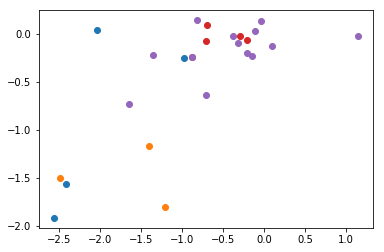

In [85]:
fig, axs = plt.subplots(squeeze=False)

for name, group in ddG_validation_mutabind2.groupby('effect-cat'):
    axs[0, 0].plot(group['minusDDG'], group['mcsm-ppi2-prediction'], marker='o',
                   linestyle='', ms=6, label=name)

MutaBind2 is probably more sensitive than mCSM-PPI2 but appears more prone to
false positives. Both in inhibitory and promoter predicitons.

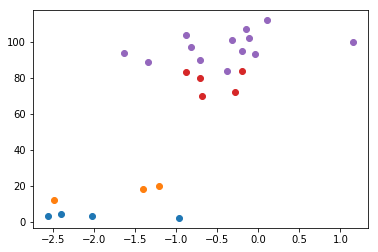

In [86]:
fig, axs = plt.subplots(squeeze=False)

for name, group in ddG_validation_mutabind2.groupby('effect-cat'):
    axs[0, 0].plot(group['minusDDG'], group['assay'], marker='o',
                   linestyle='', ms=6, label=name)

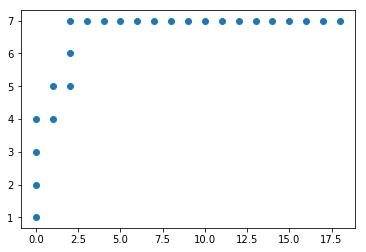

In [87]:
ddG_validation_mutabind2 = ddG_validation_mutabind2.sort_values('minusDDG')
ddG_validation_mutabind2['assay_positive'] = ddG_validation_mutabind2['effect-cat'] <= 'Strongly inhibits'

fig, axs = plt.subplots(squeeze=False)
axs[0, 0].scatter(y=ddG_validation_mutabind2['assay_positive'].cumsum(),
                  x=(~ddG_validation_mutabind2['assay_positive']).cumsum()
                 )

### PRODIGY (with mCSM-PPI2 models) validation

In [88]:
# Prodigy dG for 2ajf to calculate ddG:
# 2ajf	-10.8	1.20E-08
ddG_validation_prodigy = pd.read_csv('Prodigy/2ajf-mCSM-PPI2-models-binding-assay-mutants.csv')
ddG_validation_prodigy
ddG_validation_prodigy['mutant'] = (ddG_validation_prodigy['Protein-protein complex']
                                    .str.split('-').str[2]
                                   )
ddG_validation_prodigy = pd.merge(ddG_mutant_assays[['mutant', 'mcsm-ppi2-prediction', 'assay', 'effect-cat']],
                                  ddG_validation_prodigy,
                                  left_on='mutant', right_on='mutant')
ddG_validation_prodigy

,mutant,mcsm-ppi2-prediction,assay,effect-cat,Protein-protein complex,ΔG (kcal mol-1),Kd (M) at 25.0 ℃
0,K353D,-1.917,3.0,Abolishes interaction,158560775724-A-K353D-mut,-10.5,1.900000e-08
1,D355A,-1.802,20.0,Strongly inhibits,158560775724-A-D355A-mut,-11.2,6.400000e-09
2,K353A,-1.567,4.0,Abolishes interaction,158560775724-A-K353A-mut,-10.4,2.200000e-08
3,Y41A,-1.500,12.0,Strongly inhibits,158560775724-A-Y41A-mut,-10.4,2.500000e-08
4,R357A,-1.170,18.0,Strongly inhibits,158560775724-A-R357A-mut,-10.8,1.200000e-08
5,E37A,-0.730,94.0,No effect,158560775724-A-E37A-mut,-10.7,1.400000e-08
6,D38A,-0.633,90.0,No effect,158560775724-A-D38A-mut,-10.4,2.400000e-08
7,K31D,-0.251,2.0,Abolishes interaction,158560775724-A-K31D-mut,-10.9,9.600000e-09
8,R393A,-0.239,83.0,Slightly inhibits,158560775724-A-R393A-mut,-10.7,1.400000e-08
9,L359A,-0.238,104.0,No effect,158560775724-A-L359A-mut,-10.8,1.200000e-08


Prodigy does pretty poorly on the validation data, at least with these models.

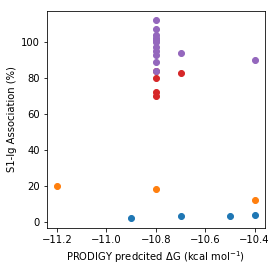

In [89]:
ig, axs = plt.subplots(squeeze=False)

for name, group in ddG_validation_prodigy.groupby('effect-cat'):
    axs[0, 0].plot(group['ΔG (kcal mol-1)'], group['assay'], marker='o',
                   linestyle='', ms=6, label=name)
    
axs[0, 0].set_xlabel('PRODIGY predcited ΔG (kcal mol$^{-1}$)')
axs[0, 0].set_ylabel('S1-Ig Association (%)')

for ax in axs.flat:
    ax.set_aspect(1./ax.get_data_ratio())
    
# _ = axs[0, 0].legend(loc='upper left')
plt.savefig('notebook_output/plot-mutagenesis-assay-vs-prodigy.svg')
plt.savefig('notebook_output/plot-mutagenesis-assay-vs-prodigy.png')

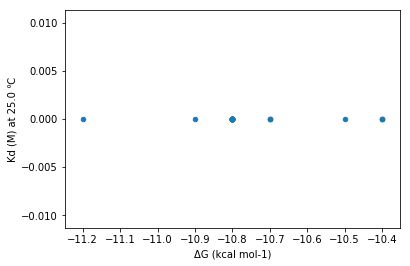

In [90]:
ax = ddG_validation_prodigy.plot.scatter(x='ΔG (kcal mol-1)', y='Kd\xa0(M) at 25.0 ℃')
# ax.set_yscale('log')
# ax.set_xscale('log')

## gnomAD missense on the interface

In [91]:
ddG_interface_gnomad = pd.read_csv('mCSM-PPI2-Predictions/6vw1/jobs/6vw1-ACE2-nCoV_S-gnomAD.csv')
ddG_interface_gnomad

,chain,wild-type,res-number,mutant,distance-to-interface,mcsm-ppi2-prediction,affinity
0,A,MET,82,ILE,3.481,-0.277,Decreasing
1,A,THR,27,ALA,3.703,-0.614,Decreasing
2,A,ASP,355,ASN,3.475,-1.335,Decreasing
3,A,GLU,37,LYS,3.185,-1.169,Decreasing
4,A,GLU,329,GLY,4.056,-0.373,Decreasing
5,A,GLU,35,LYS,2.933,-0.542,Decreasing
6,A,SER,19,PRO,2.631,-0.164,Decreasing


Format table for report

In [92]:
def mcsm_report(table, filename):
    table = table.copy()
    table['Mutation'] = ('p.' + table['wild-type'].str.capitalize()
                         + table['res-number'].astype(str)
                         + table['mutant'].str.capitalize()
                        )
    rename_mcsm_columns = {'distance-to-interface': 'Distance to Interface',
                           'mcsm-ppi2-prediction': 'mCSM-PPI2 ddG'}
    (table
     .sort_values('res-number')
     .rename(columns=rename_mcsm_columns)
     [['Mutation', 'Distance to Interface', 'mCSM-PPI2 ddG']]
     .to_csv(filename, index=False, float_format='%.3f')
    )
    return filename


mcsm_report(ddG_interface_gnomad, 'notebook_output/mCSM-PPI2-interface-gnomAD.csv')
! head notebook_output/mCSM-PPI2-interface-gnomAD.csv

Mutation,Distance to Interface,mCSM-PPI2 ddG
p.Ser19Pro,2.631,-0.164
p.Thr27Ala,3.703,-0.614
p.Glu35Lys,2.933,-0.542
p.Glu37Lys,3.185,-1.169
p.Met82Ile,3.481,-0.277
p.Glu329Gly,4.056,-0.373
p.Asp355Asn,3.475,-1.335


## All gnomAD missense

In [93]:
ddG_all_gnomad = pd.read_csv('mCSM-PPI2-Predictions/6vw1/jobs/6vw1-ACE2-gnomAD.csv')
ddG_all_gnomad

,chain,wild-type,res-number,mutant,distance-to-interface,mcsm-ppi2-prediction,affinity
0,A,THR,92,ILE,15.075,-0.084,Decreasing
1,A,HIS,378,ARG,15.254,0.056,Increasing
2,A,ILE,21,THR,7.251,0.251,Increasing
3,A,ASN,338,SER,22.884,-0.007,Decreasing
4,A,MET,270,VAL,37.737,-0.130,Decreasing
...,...,...,...,...,...,...,...
162,A,GLY,466,TRP,37.733,0.035,Increasing
163,A,ASP,216,GLU,27.303,-0.055,Decreasing
164,A,ILE,259,THR,57.223,-0.132,Decreasing
165,A,SER,547,CYS,24.330,-0.177,Decreasing


Are there outlying mcsm-ppi2-prediction scores?

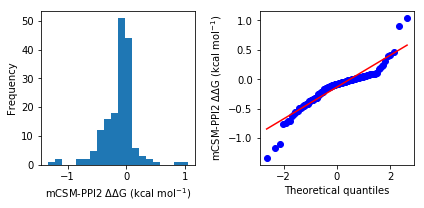

In [94]:
fig, axs = plt.subplots(1, 2, squeeze=False)

ax = ddG_all_gnomad['mcsm-ppi2-prediction'].plot.hist(ax=axs[0, 0], bins=20)
ax.set_xlabel('mCSM-PPI2 ΔΔG (kcal mol$^{-1}$)')

_ = stats.probplot(ddG_all_gnomad['mcsm-ppi2-prediction'],
                   plot=axs[0, 1])
axs[0, 1].set_title('')
axs[0, 1].set_ylabel('mCSM-PPI2 ΔΔG (kcal mol$^{-1}$)')

for ax in axs.flat:
    ax.set_aspect(1./ax.get_data_ratio())

plt.tight_layout()
plt.savefig('notebook_output/ddG_all_gnomad_distribution.svg')
plt.savefig('notebook_output/ddG_all_gnomad_distribution.png')

Note:
- inconvenient to do QQ plots in python. Will be useful to write data out
  and do some work (or at least make it easy to) in r
- I looked at per residue mean, min and max. There aren't many multiallelic
  sites. That's probably more relevant for the saturation mutagenesis.

I interpret these plots as indicating 5 variants with relatively extreme scores.
Three of these are predicted to decrease affinity whilst the other two are predicted
to increase ddG.

These can be seen in the head and tail of the table below:

In [95]:
ddG_all_gnomad.sort_values('mcsm-ppi2-prediction')

,chain,wild-type,res-number,mutant,distance-to-interface,mcsm-ppi2-prediction,affinity
89,A,ASP,355,ASN,3.475,-1.335,Decreasing
141,A,GLU,37,LYS,3.185,-1.169,Decreasing
65,A,GLY,352,VAL,5.412,-1.106,Decreasing
80,A,ASP,303,ASN,22.025,-0.759,Decreasing
152,A,GLY,268,CYS,38.918,-0.740,Decreasing
...,...,...,...,...,...,...,...
37,A,ALA,242,VAL,50.923,0.388,Increasing
145,A,ARG,518,THR,27.265,0.412,Increasing
38,A,ALA,501,THR,36.191,0.465,Increasing
47,A,VAL,447,PHE,38.508,0.905,Increasing


Hazelhurst and coworkers considered ddG >1 kcal/mol a suitible threshold
for identifying variants that significantly affect binding.

In [96]:
ddG_all_gnomad[ddG_all_gnomad['mcsm-ppi2-prediction'] < -1]

,chain,wild-type,res-number,mutant,distance-to-interface,mcsm-ppi2-prediction,affinity
65,A,GLY,352,VAL,5.412,-1.106,Decreasing
89,A,ASP,355,ASN,3.475,-1.335,Decreasing
141,A,GLU,37,LYS,3.185,-1.169,Decreasing


I'll use a alightly relaxed threshold to include the outlying value that misses
the threshold.

In [97]:
ddG_all_gnomad[ddG_all_gnomad['mcsm-ppi2-prediction'] > 0.9]

,chain,wild-type,res-number,mutant,distance-to-interface,mcsm-ppi2-prediction,affinity
47,A,VAL,447,PHE,38.508,0.905,Increasing
132,A,GLY,326,GLU,5.538,1.049,Increasing


What are the population metrics for these variants?

In [98]:
aln_variants.loc[aln_variants[('VEP', 'HGVSp')].str.contains('p.Gly326Glu').fillna(False),
                 mvps]

Type                                       Row         \
Field                                       ID FILTER   
SOURCE_ID        Protein_position                       
ACE2_HUMAN/1-805 326               rs759579097   [RF]   

Type                                                         VEP Site_INFO  \
Field                                                      HGVSp        AN   
SOURCE_ID        Protein_position                                            
ACE2_HUMAN/1-805 326               ENSP00000389326.1:p.Gly326Glu  176615.0   

Type                              Allele_INFO                           \
Field                                      AC  Hom AC_Male Hemi POPMAX   
SOURCE_ID        Protein_position                                        
ACE2_HUMAN/1-805 326                      1.0  0.0     0.0  0.0    AFR   

Type                                         
Field                             AC_POPMAX  
SOURCE_ID        Protein_position            
ACE2_HUMAN/1-805 326                    1.0

Amongst the variants with ddG > 1kcal/mol the farthest from the interface
is about 5.5 Angstrom. A threshold of about 6 Angstrom might be a good
definition for the extended interface.

In [99]:
ddG_all_gnomad.query('`distance-to-interface` < 6').sort_values('res-number')

,chain,wild-type,res-number,mutant,distance-to-interface,mcsm-ppi2-prediction,affinity
143,A,SER,19,PRO,2.631,-0.164,Decreasing
88,A,THR,27,ALA,3.703,-0.614,Decreasing
32,A,GLU,35,LYS,2.933,-0.542,Decreasing
141,A,GLU,37,LYS,3.185,-1.169,Decreasing
83,A,MET,82,ILE,3.481,-0.277,Decreasing
132,A,GLY,326,GLU,5.538,1.049,Increasing
136,A,GLU,329,GLY,4.056,-0.373,Decreasing
65,A,GLY,352,VAL,5.412,-1.106,Decreasing
89,A,ASP,355,ASN,3.475,-1.335,Decreasing


In [100]:
mcsm_report(ddG_all_gnomad.query('`distance-to-interface` < 6'),
            'notebook_output/mCSM-PPI2-extended-interface-gnomAD.csv')

'notebook_output/mCSM-PPI2-extended-interface-gnomAD.csv'

### Notes on these variants
- how buried are they?
- are they interface core or rim-like?

In [101]:
(dssp_table
 .query('CHAIN == "A"')
 .set_index('RES', drop=False)
 .loc[ddG_all_gnomad.query('`mcsm-ppi2-prediction` < -1')['res-number'].astype(str)]
 [dssp_mvps]
)

,RES,SS,RSA,RSA_UNB,RSA_CLASS,RSA_CLASS_UNB,delta-RSA,ratio-RSA
RES,,,,,,,,
352,352,E,5.952,5.952,Part. Exposed,Part. Exposed,0.000,1.000000
355,355,E,0.613,4.908,Core,Core,4.295,0.124898
37,37,H,11.856,22.165,Part. Exposed,Part. Exposed,10.309,0.534897


### The variant distribution wrt the interface

This is a convenient way to see how missense variation is located wrt the
interface. This needs to be compared the background distribution for all
residues to be useful (and sites with multiple variants need to be handled).

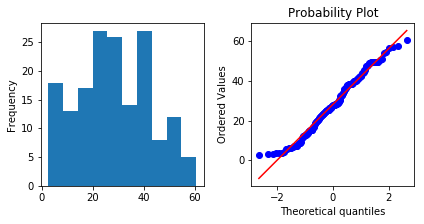

In [102]:
fig, axs = plt.subplots(1, 2, squeeze=False)

ax = ddG_all_gnomad['distance-to-interface'].plot.hist(ax=axs[0, 0])
_ = stats.probplot(ddG_all_gnomad['distance-to-interface'],
                   plot=axs[0, 1])

for ax in axs.flat:
    ax.set_aspect(1./ax.get_data_ratio())

plt.tight_layout()

Is the interface depleted? This can tell me if it is a native binding site.
If not, then modified ACE2 might be a safe treatment option.

In [103]:
n_missense = (aln_variants[is_missense]
              .groupby('Protein_position')
              .size()
              .reindex(pd.RangeIndex(1, 805), fill_value=0)
             )
n_missense.value_counts()

0    590
1    190
2     22
3      2
dtype: int64

In [104]:
_contingency = (n_missense
                .groupby(n_missense.index.isin(ace2_interface['resnum']))
                .agg(total_missense=sum, n_residues=len)
               )
_contingency

,total_missense,n_residues
False,231,779
True,9,25


In [105]:
stats.fisher_exact(_contingency.loc[[1, 0]])

(1.214025974025974, 0.6782414160637523)

The interface isn't depleted compared to the rest of the protein, but this doesn't control
for solvent accessibility.

I would expect there to be some sort of correlation between distance to the
interface and the ddG prediction. Distant variants with an effect might be
particularly interesting, if not spurious.

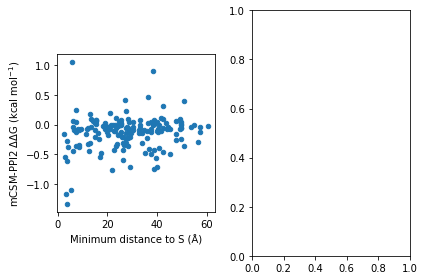

In [106]:
# ploting on 1*2 grid to make same size as other plots in panel
fig, axs = plt.subplots(1, 2, squeeze=False)

ddG_all_gnomad.plot.scatter(x='distance-to-interface', y='mcsm-ppi2-prediction', ax=axs[0, 0])

axs[0, 0].set_ylabel('mCSM-PPI2 ΔΔG (kcal mol$^{-1}$)')
axs[0, 0].set_xlabel('Minimum distance to S (Å)')

axs[0, 0].set_aspect(1./axs[0, 0].get_data_ratio())

plt.tight_layout()

plt.savefig('notebook_output/ddG-vs-distance-to-interface-all-gnomad.svg')
plt.savefig('notebook_output/ddG-vs-distance-to-interface-all-gnomad.png')

### Compare ddG from 6vw1 and 6vw1-R439N

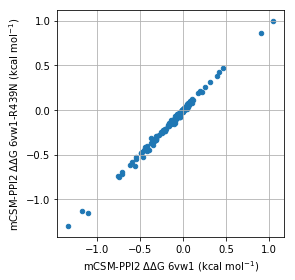

In [107]:
fig, ax =plt.subplots(1, 1)

ddG_all_gnomad_R439N = (pd.merge(pd.read_csv('mCSM-PPI2-Predictions/6vw1/jobs/6vw1-ACE2-gnomAD.csv'),
          pd.read_csv('mCSM-PPI2-Predictions/6vw1-R439N-model/gnomAD/158665174113.csv'),
          on=['chain', 'wild-type', 'res-number', 'mutant'],
          suffixes=['_chimeric', 'R439N'])
#  .query('`distance-to-interface_chimeric` < 7')  # still relativly small changes
)
ddG_all_gnomad_R439N.plot.scatter(x='mcsm-ppi2-prediction_chimeric', y='mcsm-ppi2-predictionR439N', ax=ax)


ax.set_xlabel('mCSM-PPI2 ΔΔG 6vw1 (kcal mol$^{-1}$)')
ax.set_ylabel('mCSM-PPI2 ΔΔG 6vw1-R439N (kcal mol$^{-1}$)')
    
ax.set_aspect(1./ax.get_data_ratio())
ax.grid()

plt.tight_layout()

plt.savefig('notebook_output/plot-ddG-vs-R439N-ddG.svg')
plt.savefig('notebook_output/plot-ddG-vs-R439N-ddG.png')

In [108]:
(stats.pearsonr(*ddG_all_gnomad_R439N[['mcsm-ppi2-prediction_chimeric', 'mcsm-ppi2-predictionR439N']].dropna().values.T),
stats.spearmanr(*ddG_all_gnomad_R439N[['mcsm-ppi2-prediction_chimeric', 'mcsm-ppi2-predictionR439N']].dropna().values.T)
)

((0.9979246850369676, 1.780900738779001e-198),
 SpearmanrResult(correlation=0.9947500001959226, pvalue=2.810210724002998e-165))

In [109]:
ddG_all_gnomad_R439N = pd.read_csv('mCSM-PPI2-Predictions/6vw1-R439N-model/gnomAD/158665174113.csv')
ddG_all_gnomad_R439N.query('`mcsm-ppi2-prediction` > 0.9 | `mcsm-ppi2-prediction` < -0.9')

,chain,wild-type,res-number,mutant,distance-to-interface,mcsm-ppi2-prediction,affinity
65,A,GLY,352,VAL,5.412,-1.155,Decreasing
89,A,ASP,355,ASN,3.475,-1.295,Decreasing
132,A,GLY,326,GLU,5.538,0.994,Increasing
141,A,GLU,37,LYS,3.185,-1.134,Decreasing


### Compare MutaBind2 for chimeric models

What do the MutaBind2 results look like?

In [110]:
ddG_gnomAD_MutaBind2 = my.read_MutaBind2_table('MutaBind2/gnomAD/MutaBind2.csv')
(ddG_gnomAD_MutaBind2
#  .query('`Interface?` == "yes"')
 .query('`Deleterious?` == "yes"')
 .sort_values('DDG', ascending=False)
)

,Mutated Chain,Mutation,DDG,Interface?,Deleterious?,DDE_vdw,DDG_solv,DDG_fold,CS,SA_com_wt,SA_part_wt,N_cont_wt,bootstrapFC,Model_Bias
112,A,N437H,1.57,no,yes,-0.3121,0.3055,0.8886,0.6162,-0.0205,-0.3294,-0.0029,-0.0018,0.4286
85,A,G326E,-2.04,yes,yes,-0.7751,0.1057,-0.7040,-1.1505,0.1329,-0.0645,-0.0094,-0.0018,0.4286


So MutaBind2 has lost the three variants predicted to inhibit binding but it
does predict inhibition by a different variant and it also finds G326E.

In [111]:
# my.read_mCSM_table('mCSM-PPI2-Predictions/6vw1-ACE2-gnomAD.csv')

Compare mCSM-PPI2 and MutaBind2

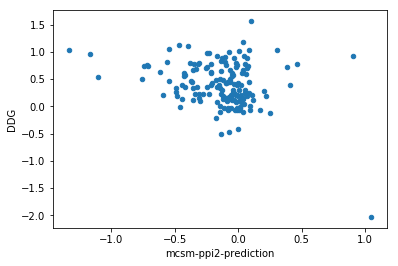

In [112]:
(pd.merge(my.read_mCSM_table('mCSM-PPI2-Predictions/6vw1/jobs/6vw1-ACE2-gnomAD.csv'),
          my.read_MutaBind2_table('MutaBind2/gnomAD/MutaBind2.csv'),
          left_on='mutation', right_on='Mutation',
          suffixes=['_chimeric_mCSM', '_chimeric_MutaBind2'])
#  .query('`distance-to-interface` < 7')  # still relativly small changes
 .plot.scatter(x='mcsm-ppi2-prediction', y='DDG')
)

What about MutaBind2 R439N model? So far I only have a selection of these.

In [113]:
paths = ['MutaBind2/R439N-model/gnomAD-interface/MutaBind2.csv',
         'MutaBind2/R439N-model/gnomAD-extended-interface/MutaBind2.csv'
        ]

pd.concat([my.read_MutaBind2_table(p) for p in paths])

,Mutated Chain,Mutation,DDG,Interface?,Deleterious?,DDE_vdw,DDG_solv,DDG_fold,CS,SA_com_wt,SA_part_wt,N_cont_wt,bootstrapFC,Model_Bias
0,A,S19P,0.24,yes,no,-0.1880,0.1057,-0.1676,0.1994,-0.2985,0.0901,0.0735,-0.0018,0.4286
1,A,T27A,0.88,yes,no,0.1773,0.0770,-0.2959,-0.0336,0.2550,0.1943,0.0814,-0.0018,0.4286
2,A,E35K,1.02,yes,no,-0.2343,0.8831,-0.2408,0.4477,-0.1872,-0.0683,-0.0054,-0.0018,0.4286
3,A,E37K,1.93,yes,yes,-0.0167,0.7611,0.9150,0.2799,-0.0440,-0.4528,0.0608,-0.0018,0.4286
4,A,M82I,0.18,yes,no,-0.1161,0.0991,-0.1634,0.1759,-0.2772,-0.0106,0.0452,-0.0018,0.4286
5,A,E329G,0.26,no,no,-0.2030,0.0143,-0.1845,0.4622,-0.3660,0.0523,0.0556,-0.0018,0.4286
6,A,D355N,1.70,yes,yes,-0.1997,0.0112,0.7802,0.4101,0.5488,-0.4023,0.1233,-0.0018,0.4286
0,A,G326E,-0.59,yes,no,-0.3665,0.5874,-0.1284,-0.7526,-0.2091,-0.2037,0.0579,-0.0018,0.4286
1,A,G352V,1.69,no,yes,0.0962,0.1547,0.9143,0.3443,0.5331,-0.9021,0.1204,-0.0018,0.4286


Hmmm... in the R439N model MutaBind2 predicts the three inhibitory mutations
mCSM-PPI2 found but not the G326E promotor. This looks like quite high
sensitivity to the input model vs. the robust results from mCSM-PPI2.

## mCSM-PPI2 Interface Saturation Mutagenesis

These data are useful in understanding the interface in general. I can use it
to identify the residues that are most critical for binding and which are most
specialised (i.e., toggles vs. rheostats).

My main objective though is to identify mutations that have a big effect on
binding since they might exist in the population, even though they haven't been
observed. Mutations that can be acheived by a SNP are more likely than those that
require MNPs. I can even consider the number of SNPs for a muation and whether
they involve CpGs or transitions vs. transversions. I can also account for the gnomAD synonymous polymorphisms
when deciding which mutants are most accesible.

First lets look at the data overall.

*Remember that here we have predictions for mutants on the S-protein too*

In [114]:
paths = [
    'mCSM-PPI2-Predictions/6vw1/jobs/saturation-scan/6vw1-ACE2-S-Saturation-scan.csv',
    'mCSM-PPI2-Predictions/6vw1/jobs/saturation-G326/158622661017.csv',  # Gly326
    'mCSM-PPI2-Predictions/6vw1/jobs/saturation-G352/158622689658.csv'  # Gly352
]

ddg_interface_saturation = []
for path in paths:
    ddg_interface_saturation.append(my.read_mCSM_table(path))

ddg_interface_saturation = pd.concat(ddg_interface_saturation, axis=0,
                                     ignore_index=True)


# ddg_interface_saturation = pd.read_csv('mCSM-PPI2-Predictions/'
#                                        '6vw1-ACE2-S-Saturation-scan.csv')
ddg_interface_saturation

,chain,wild-type,res-number,mutant,distance-to-interface,mcsm-ppi2-prediction,affinity,mutation
0,E,PHE,456,GLN,3.703,-1.180,Decreasing,F456Q
1,A,LYS,31,GLY,2.925,-0.429,Decreasing,K31G
2,A,MET,82,LYS,3.481,0.363,Increasing,M82K
3,E,PHE,490,ARG,4.175,-0.448,Decreasing,F490R
4,A,GLU,329,VAL,4.056,-0.197,Decreasing,E329V
...,...,...,...,...,...,...,...,...
907,A,GLY,352,ASN,5.412,-1.347,Decreasing,G352N
908,A,GLY,352,SER,5.412,-1.304,Decreasing,G352S
909,A,GLY,352,MET,5.412,-1.271,Decreasing,G352M
910,A,GLY,352,ARG,5.412,-1.462,Decreasing,G352R


In [115]:
(ddg_interface_saturation
#  .query('`res-number` != 326 & `res-number` != 352')
 ['chain']
 .value_counts()
)

A    475
E    437
Name: chain, dtype: int64

I left it up to mCSM-PPI2 to define the interface. What residues did it include?

SM 2020-04-07: Now I've added in Gly326 and Gly352

In [116]:
mCSM_PPI2_server_interface = (ddg_interface_saturation
                              [['chain', 'wild-type', 'res-number', 'distance-to-interface']]
#                               .query('`res-number` != 326 & `res-number` != 352')
                              .drop_duplicates()
                              .sort_values(['chain', 'res-number'])
                             )
mCSM_PPI2_server_interface.to_csv('mCSM-PPI2-Predictions/mCSM-PPI2-server-interface.csv',
                                  index=False)
mCSM_PPI2_server_interface['chain'].value_counts()  # summarise by chain, 

A    25
E    23
Name: chain, dtype: int64

How does mCSM-PPI2 define the interface?

In [117]:
(mCSM_PPI2_server_interface
 .query('`res-number` != 326 & `res-number` != 352')
 ['distance-to-interface']
 .max()
)

4.919

TODO: compare this interface to ProIntVar/ Arpeggio's definition

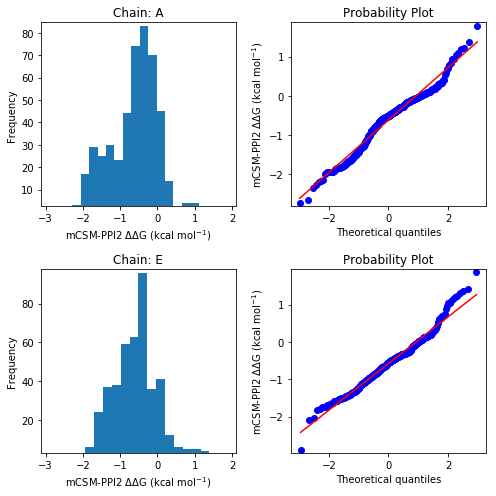

In [118]:
fig, axs = plt.subplots(2, 2, squeeze=False, figsize=[7, 7], sharex='col')

for i, (gid, gdf) in enumerate(ddg_interface_saturation.groupby('chain')):
    ax = gdf['mcsm-ppi2-prediction'].plot.hist(ax=axs[i, 0], bins=20)
    ax.set_title(f'Chain: {gid}')
    ax.set_xlabel('mCSM-PPI2 ΔΔG (kcal mol$^{-1}$)')
    _ = stats.probplot(gdf['mcsm-ppi2-prediction'],
                       plot=axs[i, 1])
    axs[i, 1].set_ylabel('mCSM-PPI2 ΔΔG (kcal mol$^{-1}$)')

for ax in axs.flat:
    ax.set_aspect(1./ax.get_data_ratio())
    ax.xaxis.set_tick_params(labelbottom=True)
    ax.set_xlabel(ax.xaxis.get_label().get_text(), visible=True)

plt.tight_layout()

plt.savefig('notebook_output/mCSM-PPI2-ddG-saturation.svg')
plt.savefig('notebook_output/mCSM-PPI2-ddG-saturation.png')

I'm curious as to why these have different shapes. For example, ACE2 has
a shoulder of inhibitory mutations that the S-protein doesn't. Could the
S-protein have evolved to be stable with respect to variants in its own
RBD?

There are quite a few mutants that meet the |ddG| > 1 kcal/mol criteria

In [119]:
(ddg_interface_saturation
#  .query('`res-number` != 326 & `res-number` != 352')  # shows the mCSM-PPI2 definition
 .loc[ddg_interface_saturation['mcsm-ppi2-prediction'] < -1, 'chain']
 .value_counts()
)

A    125
E    108
Name: chain, dtype: int64

In [120]:
(ddg_interface_saturation
#  .query('`res-number` != 326 & `res-number` != 352')
 .loc[ddg_interface_saturation['mcsm-ppi2-prediction'] > 1, 'chain']
 .value_counts()
)

E    10
A     6
Name: chain, dtype: int64

In [121]:
(ddg_interface_saturation
#  .query('`res-number` != 326 & `res-number` != 352')
 .loc[ddg_interface_saturation['mcsm-ppi2-prediction'] > 0.5, 'chain']
 .value_counts()
)

E    22
A    14
Name: chain, dtype: int64

Notes
- If you want more detail, you can look at the min and max per residue too.
  E.g., `ddg_interface_saturation.groupby(['chain', 'res-number']).min()`

### Compare to results for R439N

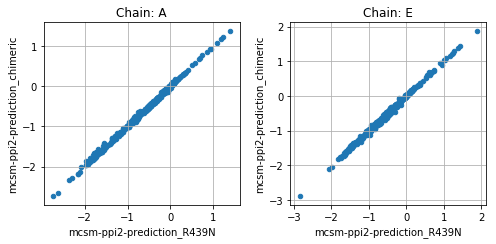

In [122]:
ddG_satn_6vw1_vsR439N = (pd.merge(my.read_mCSM_table('mCSM-PPI2-Predictions/6vw1-R439N-model/saturation-scan/158734016892.csv'),
                                  ddg_interface_saturation[['mutation', 'mcsm-ppi2-prediction', 'distance-to-interface']],
                                  on='mutation', suffixes=('_R439N', '_chimeric'))
)

fig, axs = plt.subplots(1, 2, squeeze=False, figsize=[7, 3.5], sharex='col')

for i, (gid, gdf) in enumerate(ddG_satn_6vw1_vsR439N.groupby('chain')):
    ax = gdf.plot.scatter(x='mcsm-ppi2-prediction_R439N', y='mcsm-ppi2-prediction_chimeric', ax=axs[0, i])
    ax.set_title(f'Chain: {gid}')
#     ax.set_xlabel('mCSM-PPI2 ddG (kcal/mol)')
    ax.grid()
    
plt.tight_layout()

### Compare to results for 6lzq

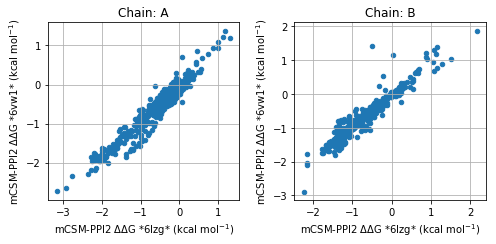

In [123]:
ddG_satn_6vw1_6lzg = (pd.merge(my.read_mCSM_table('mCSM-PPI2-Predictions/6lzg/jobs/saturation-scan/158733965972.csv'),
                               ddg_interface_saturation[['mutation', 'mcsm-ppi2-prediction', 'distance-to-interface']],
                               on='mutation', suffixes=('_6lzg', '_6vw1'))
)

fig, axs = plt.subplots(1, 2, squeeze=False, figsize=[7, 3.5], sharex='col')

for i, (gid, gdf) in enumerate(ddG_satn_6vw1_6lzg.groupby('chain')):
    ax = gdf.plot.scatter(x='mcsm-ppi2-prediction_6lzg', y='mcsm-ppi2-prediction_6vw1', ax=axs[0, i])
    ax.set_title(f'Chain: {gid}')
#     ax.set_xlabel('mCSM-PPI2 ddG (kcal/mol)')
    ax.grid()
    ax.set_xlabel('mCSM-PPI2 ΔΔG *6lzg* (kcal mol$^{-1}$)')
    ax.set_ylabel('mCSM-PPI2 ΔΔG *6vw1* (kcal mol$^{-1}$)')

plt.tight_layout()

plt.savefig('notebook_output/mCSM-PPI2-ddG-6vw1-vs-6lzg.svg')
plt.savefig('notebook_output/mCSM-PPI2-ddG-6vw1-vs-6lzg.png')

In [124]:
(stats.pearsonr(*ddG_satn_6vw1_6lzg.query('chain == "A"')[['mcsm-ppi2-prediction_6vw1', 'mcsm-ppi2-prediction_6lzg']].dropna().values.T),
stats.spearmanr(*ddG_satn_6vw1_6lzg.query('chain == "A"')[['mcsm-ppi2-prediction_6vw1', 'mcsm-ppi2-prediction_6lzg']].dropna().values.T)
)

((0.9655529161571522, 2.397833353344918e-245),
 SpearmanrResult(correlation=0.9603247974134147, pvalue=8.0508455603469286e-233))

Can expect something very similar with R439N model.

What are the two that are predicted promoters in 6vw1 (> 1 kcal/mol) and
neutral in 6lzg (~0 kcal/mol)?

In [125]:
ddG_satn_6vw1_6lzg.query('`mcsm-ppi2-prediction_6vw1` > 1 & `mcsm-ppi2-prediction_6lzg` < 1')

,chain,wild-type,res-number,mutant,distance-to-interface_6lzg,mcsm-ppi2-prediction_6lzg,affinity,mutation,mcsm-ppi2-prediction_6vw1,distance-to-interface_6vw1
39,B,ALA,475,GLU,2.813,0.893,Increasing,A475E,1.032,2.631
215,B,ASN,501,VAL,3.115,0.041,Increasing,N501V,1.147,3.277
333,B,ASN,501,THR,3.115,0.873,Increasing,N501T,1.228,3.277
565,B,ALA,475,PRO,2.813,-0.509,Decreasing,A475P,1.433,2.631
790,B,GLY,496,ASP,3.250,0.873,Increasing,G496D,1.104,2.980


What's the agreement between the gnomAD variants on the interface and other important mutations?

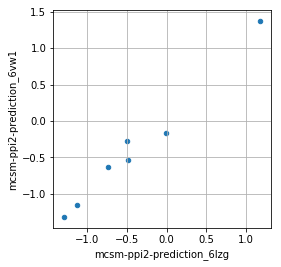

In [126]:
fig, ax = plt.subplots(1, 1)

(ddG_satn_6vw1_6lzg
 .set_index('mutation')
 .loc[(['D355N','M82I', 'E37K', 'E35K', 'T27A', 'S19P',   'T27R'])]  # T27R is not in gnomAD
 .plot.scatter(x='mcsm-ppi2-prediction_6lzg', y='mcsm-ppi2-prediction_6vw1', ax=ax)
)

ax.set_aspect(1./ax.get_data_ratio())
ax.grid()

### What mutations are most accessible


This what I need to do:

1. Get all codons (including observed synonymous variants)
2. Enumerate SNPs
3. Translate

I have easy access to the codons for variant sites from the alignment variant
table but I need non-variant sites too. I'll try Jalview. Sure I can get it
with ProteoFAV but right now this is easiest.

In [127]:
# Parse CDS
ace2_cds = Bio.AlignIO.read('ACE2_CDS.fa', format='fasta')[0]
ace2_cds = str(ace2_cds.seq)
# Split into codons
n = 3
ace2_codons = pd.Series([ace2_cds[i:i+n] for i in range(0, len(ace2_cds), n)])
ace2_codons.index += 1  # convert to 1-index
ace2_codons.name = 'cds'
ace2_codons

1      ATG
2      TCA
3      AGC
4      TCT
5      TCC
      ... 
801    GTT
802    CAG
803    ACC
804    TCC
805    TTT
Name: cds, Length: 805, dtype: object

Here's a SNP table

In [128]:
snp_table = pd.read_csv('snp_table.csv')
snp_table

,from_codon,to_codon,from_aa,to_aa,n_subs
0,TTT,TTC,F,F,1
1,TTT,TTA,F,L,1
2,TTT,TTG,F,L,1
3,TTT,TCT,F,S,1
4,TTT,TAT,F,Y,1
...,...,...,...,...,...
521,GGG,GCG,G,A,1
522,GGG,GAG,G,E,1
523,GGG,GGT,G,G,1
524,GGG,GGC,G,G,1


In [129]:
ace2_snp_accesible_aa = (snp_table
                         .groupby(['from_codon'])['to_aa']
#                          .unique()
                         .apply(list)  # keep duplicates to count number of SNPs
                         .loc[ace2_codons.unique()]
                        )
# ace2_snp_accesible_aa = ace2_snp_accesible_aa.drop_duplicates()
ace2_snp_accesible_aa = ace2_snp_accesible_aa.reset_index()
ace2_snp_accesible_aa

,from_codon,to_aa
0,ATG,"[L, L, I, I, I, T, K, R, V]"
1,TCA,"[L, S, S, S, P, T, A]"
2,AGC,"[C, R, I, T, N, S, R, R, G]"
3,TCT,"[F, S, S, S, Y, C, P, T, A]"
4,TCC,"[F, S, S, S, Y, C, P, T, A]"
5,TGG,"[L, S, C, C, R, R, G]"
6,CTC,"[F, L, L, L, P, H, R, I, V]"
7,CTT,"[F, L, L, L, P, H, R, I, V]"
8,GTT,"[F, L, I, V, V, V, A, D, G]"
9,GCT,"[S, P, T, V, A, A, A, D, G]"


Take the opportunity to verify the CDS

In [130]:
# codon map, n.b. dict uniquifies keys
genetic_code = {row['from_codon']: row['from_aa'] for _, row in snp_table.iterrows()}
# compare translated CDS with UniProt sequence
assert ''.join(ace2_codons.map(genetic_code).values) == str(aln[0].seq)

And label CGs... How many are there?

In [131]:
contains_CG = ace2_codons.str.contains('CG')
contains_CG = contains_CG | ((ace2_codons.shift(-1).str[0] + ace2_codons.str[0]) == 'CG')
contains_CG.name = 'contains_CG'
contains_CG.sum()

55

In [132]:
ddg_interface_saturation_ace2 = ddg_interface_saturation.query('chain == "A"').copy()
# merge codon
ddg_interface_saturation_ace2.loc[:, 'codon'] = \
    ace2_codons[ddg_interface_saturation_ace2['res-number'].values].values
# 3-to-1 AA
ddg_interface_saturation_ace2['_mutant'] = \
    ddg_interface_saturation_ace2['mutant'].map(prointvar.library.aa_codes_3to1_common)
# add SNP accesible residues
ddg_interface_saturation_ace2 = pd.merge(ddg_interface_saturation_ace2, ace2_snp_accesible_aa,
                                         left_on='codon', right_on='from_codon')
# label if accesible from SNP
ddg_interface_saturation_ace2['from_snp'] = \
    ddg_interface_saturation_ace2.apply(lambda x: x['_mutant'] in x['to_aa'], axis=1)
# count number of SNPs
ddg_interface_saturation_ace2['n_snp'] = \
    ddg_interface_saturation_ace2.apply(lambda x: x['to_aa'].count(x['_mutant']), axis=1)

# label CGs
ddg_interface_saturation_ace2 = pd.merge(ddg_interface_saturation_ace2, contains_CG,
                                         left_on='res-number', right_index=True)

ddg_interface_saturation_ace2 = ddg_interface_saturation_ace2.sort_values('mcsm-ppi2-prediction')
ddg_interface_saturation_ace2.query('from_snp')

,chain,wild-type,res-number,mutant,distance-to-interface,mcsm-ppi2-prediction,affinity,mutation,codon,_mutant,from_codon,to_aa,from_snp,n_snp,contains_CG
212,A,TYR,41,ASP,2.623,-2.653,Decreasing,Y41D,TAT,D,TAT,"[F, S, Y, C, H, N, D]",True,1,False
210,A,TYR,41,CYS,2.623,-1.932,Decreasing,Y41C,TAT,C,TAT,"[F, S, Y, C, H, N, D]",True,1,False
300,A,PHE,28,VAL,3.376,-1.928,Decreasing,F28V,TTT,V,TTT,"[F, L, L, S, Y, C, L, I, V]",True,1,False
215,A,TYR,41,SER,2.623,-1.867,Decreasing,Y41S,TAT,S,TAT,"[F, S, Y, C, H, N, D]",True,1,False
286,A,PHE,28,LEU,3.376,-1.844,Decreasing,F28L,TTT,L,TTT,"[F, L, L, S, Y, C, L, I, V]",True,3,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
332,A,GLN,42,GLU,3.094,0.774,Increasing,Q42E,CAA,E,CAA,"[L, P, H, H, Q, R, K, E]",True,1,False
221,A,TYR,41,ASN,2.623,0.846,Increasing,Y41N,TAT,N,TAT,"[F, S, Y, C, H, N, D]",True,1,False
32,A,LYS,31,GLU,2.925,0.940,Increasing,K31E,AAG,E,AAG,"[Q, M, T, N, N, K, R, E]",True,1,False
454,A,GLY,326,GLU,5.538,1.049,Increasing,G326E,GGA,E,GGA,"[R, R, V, A, E, G, G, G]",True,1,False


How many mutations?

In [133]:
len(ddg_interface_saturation_ace2.query('from_snp'))

151

How many SNPs?

In [134]:
ddg_interface_saturation_ace2.query('from_snp')['n_snp'].sum()

172

What's the distribution of predicted ddG for these mutations?

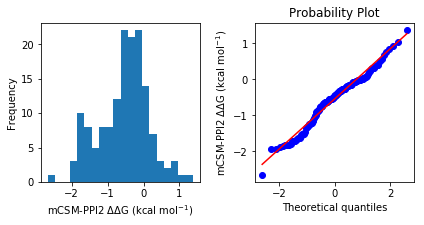

In [135]:
fig, axs = plt.subplots(1, 2, squeeze=False)

ax = (ddg_interface_saturation_ace2
      .query('from_snp')
      ['mcsm-ppi2-prediction']
      .plot.hist(ax=axs[0, 0], bins=20)
     )
ax.set_xlabel('mCSM-PPI2 ΔΔG (kcal mol$^{-1}$)')
_ = stats.probplot(ddg_interface_saturation_ace2
                   .query('from_snp')
                   ['mcsm-ppi2-prediction'],
                   plot=axs[0, 1])
axs[0, 1].set_ylabel('mCSM-PPI2 ΔΔG (kcal mol$^{-1}$)')


for ax in axs.flat:
    ax.set_aspect(1./ax.get_data_ratio())

plt.tight_layout()

plt.savefig('notebook_output/mCSM-PPI2-ddG-saturation-single-base-change.svg')
plt.savefig('notebook_output/mCSM-PPI2-ddG-saturation-single-base-change.png')

What about if we aggregate over positions?

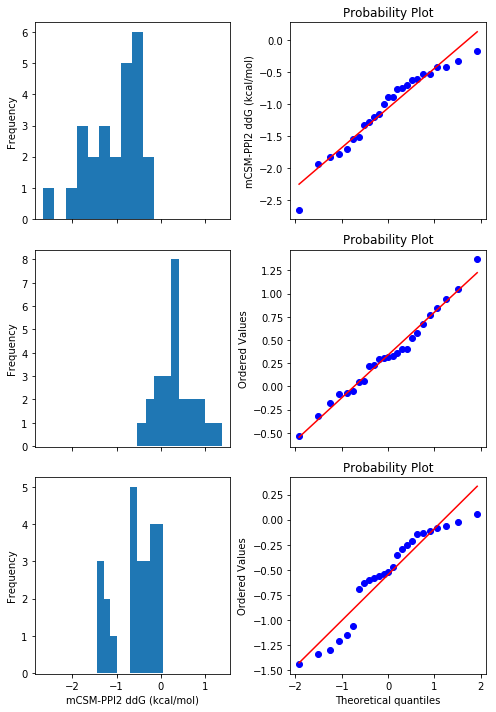

In [136]:
fig, axs = plt.subplots(3, 2, figsize=[7, 10], sharex='col', squeeze=False)

for i, agg in enumerate(['min', 'max', 'mean']):
    ax = (ddg_interface_saturation_ace2
          .query('from_snp')
          .groupby('res-number')
          ['mcsm-ppi2-prediction']
          .agg(agg)
          .plot.hist(ax=axs[i, 0], bins=10)
         )
    ax.set_xlabel('mCSM-PPI2 ddG (kcal/mol)')
    _ = stats.probplot(ddg_interface_saturation_ace2
                       .query('from_snp')
                       .groupby('res-number')
                       ['mcsm-ppi2-prediction']
                       .agg(agg),
                       plot=axs[i, 1])
    axs[0, 1].set_ylabel('mCSM-PPI2 ddG (kcal/mol)')


for ax in axs.flat:
    ax.set_aspect(1./ax.get_data_ratio())

plt.tight_layout()

# plt.savefig('notebook_output/mCSM-PPI2-ddG-saturation-single-base-change-min.svg')
# plt.savefig('notebook_output/mCSM-PPI2-ddG-saturation-single-base-change-min.png')

Which of these are predicted to affect a decrease in affinity?

In [137]:
ddg_interface_saturation_ace2.query('from_snp & `mcsm-ppi2-prediction` < -1').sort_values(by='res-number')

,chain,wild-type,res-number,mutant,distance-to-interface,mcsm-ppi2-prediction,affinity,mutation,codon,_mutant,from_codon,to_aa,from_snp,n_snp,contains_CG
300,A,PHE,28,VAL,3.376,-1.928,Decreasing,F28V,TTT,V,TTT,"[F, L, L, S, Y, C, L, I, V]",True,1,False
286,A,PHE,28,LEU,3.376,-1.844,Decreasing,F28L,TTT,L,TTT,"[F, L, L, S, Y, C, L, I, V]",True,3,False
301,A,PHE,28,CYS,3.376,-1.838,Decreasing,F28C,TTT,C,TTT,"[F, L, L, S, Y, C, L, I, V]",True,1,False
302,A,PHE,28,ILE,3.376,-1.832,Decreasing,F28I,TTT,I,TTT,"[F, L, L, S, Y, C, L, I, V]",True,1,False
299,A,PHE,28,SER,3.376,-1.617,Decreasing,F28S,TTT,S,TTT,"[F, L, L, S, Y, C, L, I, V]",True,1,False
2,A,LYS,31,ARG,2.925,-1.199,Decreasing,K31R,AAG,R,AAG,"[Q, M, T, N, N, K, R, E]",True,1,False
10,A,LYS,31,MET,2.925,-1.221,Decreasing,K31M,AAG,M,AAG,"[Q, M, T, N, N, K, R, E]",True,1,False
12,A,LYS,31,GLN,2.925,-1.506,Decreasing,K31Q,AAG,Q,AAG,"[Q, M, T, N, N, K, R, E]",True,1,False
80,A,GLU,35,ALA,2.933,-1.003,Decreasing,E35A,GAA,A,GAA,"[Q, K, V, A, D, D, E, G]",True,1,False
74,A,GLU,37,LYS,3.185,-1.152,Decreasing,E37K,GAA,K,GAA,"[Q, K, V, A, D, D, E, G]",True,1,False


How many substitutions per site?

In [138]:
ddg_interface_saturation_ace2.query('from_snp & `mcsm-ppi2-prediction` < -1')['res-number'].value_counts()

354    5
28     5
83     5
41     4
355    4
352    4
38     3
31     3
353    2
37     1
79     1
35     1
Name: res-number, dtype: int64

How many substitutions?

In [139]:
ddg_interface_saturation_ace2.query('from_snp & `mcsm-ppi2-prediction` < -1')['res-number'].value_counts().sum()

38

How many SNPs?

In [140]:
ddg_interface_saturation_ace2.query('from_snp & `mcsm-ppi2-prediction` < -1')['n_snp'].sum()

41

These are potential risk factors

In [141]:
ddg_interface_saturation_ace2.query('from_snp & `mcsm-ppi2-prediction` > 1')

,chain,wild-type,res-number,mutant,distance-to-interface,mcsm-ppi2-prediction,affinity,mutation,codon,_mutant,from_codon,to_aa,from_snp,n_snp,contains_CG
454,A,GLY,326,GLU,5.538,1.049,Increasing,G326E,GGA,E,GGA,"[R, R, V, A, E, G, G, G]",True,1,False
344,A,THR,27,ARG,3.703,1.372,Increasing,T27R,ACA,R,ACA,"[S, P, I, T, T, T, K, R, A]",True,1,False


T27 is a Lys in certain bats, which might include the source species... what's T27K?

In [142]:
(ddg_interface_saturation_ace2
 .set_index('mutation')
 .loc[['T27K', # Greaterhorshoe bat
       'E329N', # Bats and civet, not mouse or rat
       'M82N',
       'E37N'  # civet
      ]
     ]
)

,chain,wild-type,res-number,mutant,distance-to-interface,mcsm-ppi2-prediction,affinity,codon,_mutant,from_codon,to_aa,from_snp,n_snp,contains_CG
mutation,,,,,,,,,,,,,,
T27K,A,THR,27,LYS,3.703,-0.017,Decreasing,ACA,K,ACA,"[S, P, I, T, T, T, K, R, A]",True,1,False
E329N,A,GLU,329,ASN,4.056,0.231,Increasing,GAA,N,GAA,"[Q, K, V, A, D, D, E, G]",False,0,False
M82N,A,MET,82,ASN,3.481,-0.374,Decreasing,ATG,N,ATG,"[L, L, I, I, I, T, K, R, V]",False,0,False
E37N,A,GLU,37,ASN,3.185,-0.830,Decreasing,GAA,N,GAA,"[Q, K, V, A, D, D, E, G]",False,0,False


Well I thought that might be an enhancer too, that just missed the cutoff, but it doesn't
look like it.

Any from Arg? Yes, but none have CG containing codon 

In [143]:
ddg_interface_saturation_ace2.query('from_snp & `wild-type` == "ARG"')

,chain,wild-type,res-number,mutant,distance-to-interface,mcsm-ppi2-prediction,affinity,mutation,codon,_mutant,from_codon,to_aa,from_snp,n_snp,contains_CG
381,A,ARG,357,GLY,3.595,-0.891,Decreasing,R357G,AGG,G,AGG,"[W, R, M, T, K, S, S, R, G]",True,1,False
398,A,ARG,357,MET,3.595,-0.848,Decreasing,R357M,AGG,M,AGG,"[W, R, M, T, K, S, S, R, G]",True,1,False
380,A,ARG,357,LYS,3.595,-0.769,Decreasing,R357K,AGG,K,AGG,"[W, R, M, T, K, S, S, R, G]",True,1,False
391,A,ARG,357,THR,3.595,-0.675,Decreasing,R357T,AGG,T,AGG,"[W, R, M, T, K, S, S, R, G]",True,1,False
394,A,ARG,357,SER,3.595,-0.623,Decreasing,R357S,AGG,S,AGG,"[W, R, M, T, K, S, S, R, G]",True,2,False
435,A,ARG,393,GLY,3.533,-0.524,Decreasing,R393G,AGA,G,AGA,"[R, I, T, K, S, S, R, G]",True,1,False
433,A,ARG,393,ILE,3.533,-0.456,Decreasing,R393I,AGA,I,AGA,"[R, I, T, K, S, S, R, G]",True,1,False
387,A,ARG,357,TRP,3.595,-0.323,Decreasing,R357W,AGG,W,AGG,"[W, R, M, T, K, S, S, R, G]",True,1,False
423,A,ARG,393,THR,3.533,-0.297,Decreasing,R393T,AGA,T,AGA,"[R, I, T, K, S, S, R, G]",True,1,False
430,A,ARG,393,LYS,3.533,-0.287,Decreasing,R393K,AGA,K,AGA,"[R, I, T, K, S, S, R, G]",True,1,False


Any other CGs? Also need to account for the C in the preceeding codon.

In [144]:
(ddg_interface_saturation_ace2
#  .where(ddg_interface_saturation_ace2['codon'].str.contains('CG')).dropna()
 .query('from_snp & contains_CG')
)

,chain,wild-type,res-number,mutant,distance-to-interface,mcsm-ppi2-prediction,affinity,mutation,codon,_mutant,from_codon,to_aa,from_snp,n_snp,contains_CG
136,A,ASP,38,ALA,2.991,-1.201,Decreasing,D38A,GAC,A,GAC,"[Y, H, N, V, A, D, E, E, G]",True,1,True
141,A,ASP,38,GLY,2.991,-1.023,Decreasing,D38G,GAC,G,GAC,"[Y, H, N, V, A, D, E, E, G]",True,1,True
168,A,ASP,38,ASN,2.991,-1.007,Decreasing,D38N,GAC,N,GAC,"[Y, H, N, V, A, D, E, E, G]",True,1,True
186,A,ASP,38,GLU,2.991,-0.437,Decreasing,D38E,GAC,E,GAC,"[Y, H, N, V, A, D, E, E, G]",True,2,True
183,A,ASP,38,HIS,2.991,-0.333,Decreasing,D38H,GAC,H,GAC,"[Y, H, N, V, A, D, E, E, G]",True,1,True
147,A,ASP,38,TYR,2.991,-0.143,Decreasing,D38Y,GAC,Y,GAC,"[Y, H, N, V, A, D, E, E, G]",True,1,True
145,A,ASP,38,VAL,2.991,0.233,Increasing,D38V,GAC,V,GAC,"[Y, H, N, V, A, D, E, E, G]",True,1,True


## What might a resistant ACE2 look like?

For example, to engineer a gene therapy...

In [145]:
min_mutants = (ddg_interface_saturation
#                .query('mutant != "PRO"')  # can add other constraints like this
               .groupby(['chain', 'res-number'])
               ['mcsm-ppi2-prediction']
               .idxmax()  # max or min depending on goal
              )
min_mutants = ddg_interface_saturation.loc[min_mutants]
(min_mutants
 .query('chain == "A"')
 .sort_values('mcsm-ppi2-prediction', ascending=False)
)

,chain,wild-type,res-number,mutant,distance-to-interface,mcsm-ppi2-prediction,affinity,mutation
906,A,GLY,352,TYR,5.412,1.786,Increasing,G352Y
84,A,THR,27,ARG,3.703,1.372,Increasing,T27R
67,A,LEU,79,TRP,3.541,1.228,Increasing,L79W
365,A,PHE,28,TRP,3.376,1.182,Increasing,F28W
891,A,GLY,326,GLU,5.538,1.049,Increasing,G326E
738,A,LYS,31,GLU,2.925,0.940,Increasing,K31E
616,A,LEU,45,GLU,3.851,0.933,Increasing,L45E
709,A,TYR,41,ASN,2.623,0.846,Increasing,Y41N
409,A,GLN,42,GLU,3.094,0.774,Increasing,Q42E
376,A,LYS,353,HIS,2.820,0.704,Increasing,K353H


## mouse ACE2 vs. human ACE2

In [146]:
mACE2_substitutions = ['GLN', 24, 'ASN',
                       'LYS', 31, 'ASN',
                       'HIS', 34, 'GLN',
                       'LEU', 79, 'THR',
                       'MET', 82, 'SER',
                       'TYR', 83, 'PHE',
                       'LYS', 353, 'HIS']
mACE2_substitutions = zip(mACE2_substitutions[::3],
                          mACE2_substitutions[1::3],
                          mACE2_substitutions[2::3])
mACE2_substitutions = pd.MultiIndex.from_tuples(mACE2_substitutions)
mACE2_substitutions = (ddg_interface_saturation
                       .set_index(['wild-type', 'res-number', 'mutant'])
                       .loc[mACE2_substitutions]
                      )
mACE2_substitutions

,,,chain,distance-to-interface,mcsm-ppi2-prediction,affinity,mutation
GLN,24,ASN,A,3.031,-0.393,Decreasing,Q24N
LYS,31,ASN,A,2.925,0.085,Increasing,K31N
HIS,34,GLN,A,3.049,0.025,Increasing,H34Q
LEU,79,THR,A,3.541,-0.581,Decreasing,L79T
MET,82,SER,A,3.481,-0.505,Decreasing,M82S
TYR,83,PHE,A,2.933,0.672,Increasing,Y83F
LYS,353,HIS,A,2.820,0.704,Increasing,K353H


n.b. different score for Lys353His here compared to mutagenesis assay
prediction because they're calculated on different structures.

Hmmmmm, some bigger affinity increases there. What's the sum total?

In [147]:
mACE2_substitutions['mcsm-ppi2-prediction'].sum()

0.007000000000000339

Are there any other mACE2 diferences I have predictions for?

In [148]:
# For convenience
def compute_substitutions(fasta_path):
    """Read alignment of two sequences and parse substitutions"""
    pairwise_aln = Bio.AlignIO.read(fasta_path, 'fasta')
    substitutions = []
    for i, (seq_1, seq_2) in enumerate(zip(*pairwise_aln), start=1):
        if seq_1 != seq_2:
            substitutions.append([seq_1, i, seq_2])
    substitutions = pd.DataFrame(substitutions,
                                 columns=['wild-type', 'res-number', 'mutant'])
    substitutions.loc[:, 'wild-type'] = (substitutions['wild-type']
                                         .map(prointvar.library.aa_codes_1to3_common))
    substitutions.loc[:, 'mutant'] = (substitutions['mutant']
                                      .map(prointvar.library.aa_codes_1to3_common))
    substitutions = pd.MultiIndex.from_frame(substitutions)
    return substitutions


def lookup_substitutions_in_ddG_table(substitutions, ddG_table):
    """lookup in mCSM-PPI2 predictions"""
    return (ddG_table
            .set_index(['wild-type', 'res-number', 'mutant'])
            .reindex(substitutions)
            .dropna()
           )

In [149]:
mACE2_substitutions_all = compute_substitutions('hACE2-vs-mACE2/hACE2-vs-mACE2.fa')
mACE2_predictions = lookup_substitutions_in_ddG_table(mACE2_substitutions_all,
                                                      ddg_interface_saturation)
mACE2_predictions.sort_values('res-number')

,,,chain,distance-to-interface,mcsm-ppi2-prediction,affinity,mutation
wild-type,res-number,mutant,,,,,
GLN,24,ASN,A,3.031,-0.393,Decreasing,Q24N
ASP,30,ASN,A,4.116,-0.598,Decreasing,D30N
LYS,31,ASN,A,2.925,0.085,Increasing,K31N
HIS,34,GLN,A,3.049,0.025,Increasing,H34Q
LEU,79,THR,A,3.541,-0.581,Decreasing,L79T
MET,82,SER,A,3.481,-0.505,Decreasing,M82S
TYR,83,PHE,A,2.933,0.672,Increasing,Y83F
GLU,329,ALA,A,4.056,-0.535,Decreasing,E329A
LYS,353,HIS,A,2.820,0.704,Increasing,K353H


K353H in mouse relative in human is actually thought to be a big factor in the
poor binding to mouse ACE2. Might be a problem with this site in the predictor.

In [150]:
mACE2_predictions['mcsm-ppi2-prediction'].sum()

-1.1259999999999994

### Test other ACE2s

My assessment of the microsopy images in Zheng-Li Shi report:
human ~ civet > pig > bat > mouse = nil

civet

In [151]:
civet_substitutions_all = compute_substitutions('hACE2-vs-orthologs/hACE2-vs-civetACE2.fa')
civet_predictions = lookup_substitutions_in_ddG_table(civet_substitutions_all,
                                                      ddg_interface_saturation)
civet_predictions

,,,chain,distance-to-interface,mcsm-ppi2-prediction,affinity,mutation
wild-type,res-number,mutant,,,,,
GLN,24,LEU,A,3.031,-0.531,Decreasing,Q24L
ASP,30,GLU,A,4.116,0.571,Increasing,D30E
LYS,31,THR,A,2.925,-0.581,Decreasing,K31T
HIS,34,TYR,A,3.049,-0.158,Decreasing,H34Y
GLU,37,GLN,A,3.185,0.215,Increasing,E37Q
ASP,38,GLU,A,2.991,-0.437,Decreasing,D38E
LEU,45,VAL,A,3.851,-0.540,Decreasing,L45V
MET,82,THR,A,3.481,-0.191,Decreasing,M82T


In [152]:
civet_predictions['mcsm-ppi2-prediction'].sum()

-1.6520000000000001

pig

In [153]:
pig_substitutions_all = compute_substitutions('hACE2-vs-orthologs/hACE2-vs-pigACE2.fa')
pig_predictions = lookup_substitutions_in_ddG_table(pig_substitutions_all,
                                                    ddg_interface_saturation)
pig_predictions

,,,chain,distance-to-interface,mcsm-ppi2-prediction,affinity,mutation
wild-type,res-number,mutant,,,,,
GLN,24,LEU,A,3.031,-0.531,Decreasing,Q24L
ASP,30,GLU,A,4.116,0.571,Increasing,D30E
HIS,34,LEU,A,3.049,-0.592,Decreasing,H34L
LEU,79,ILE,A,3.541,-0.474,Decreasing,L79I
MET,82,THR,A,3.481,-0.191,Decreasing,M82T
GLU,329,ASN,A,4.056,0.231,Increasing,E329N


In [154]:
pig_predictions['mcsm-ppi2-prediction'].sum()

-0.9860000000000001

n.b. there are other pig sequences in UniProt

Chinese horseshoe bat (also has multiple UniProt entries)

In [155]:
bat_substitutions_all = compute_substitutions('hACE2-vs-orthologs/hACE2-vs-batACE2.fa')
bat_predictions = lookup_substitutions_in_ddG_table(bat_substitutions_all,
                                                    ddg_interface_saturation)
bat_predictions

,,,chain,distance-to-interface,mcsm-ppi2-prediction,affinity,mutation
wild-type,res-number,mutant,,,,,
GLN,24,LEU,A,3.031,-0.531,Decreasing,Q24L
THR,27,LYS,A,3.703,-0.017,Decreasing,T27K
LYS,31,ASP,A,2.925,-0.973,Decreasing,K31D
HIS,34,SER,A,3.049,-0.432,Decreasing,H34S
ASP,38,ASN,A,2.991,-1.007,Decreasing,D38N
TYR,41,HIS,A,2.623,-1.526,Decreasing,Y41H
MET,82,ASN,A,3.481,-0.374,Decreasing,M82N
TYR,83,PHE,A,2.933,0.672,Increasing,Y83F
GLU,329,ASN,A,4.056,0.231,Increasing,E329N


In [156]:
bat_predictions['mcsm-ppi2-prediction'].sum()

-3.9570000000000007

Here's an additional bat ACE2 that was described in Hoffmann paper as able
to affect SARS-CoV-2 infeaction. It's actually labelled as ACE in UniProt
but comparison in Jalview with ACE and ACE2 in human suggest it is ACE2.

In [157]:
bat2_substitutions_all = compute_substitutions('hACE2-vs-orthologs/Rhinolophus-alcyone/'
                                               'hACE2-vs-RHIAY.fa')
bat2_predictions = lookup_substitutions_in_ddG_table(bat2_substitutions_all,
                                                     ddg_interface_saturation)
bat2_predictions

,,,chain,distance-to-interface,mcsm-ppi2-prediction,affinity,mutation
wild-type,res-number,mutant,,,,,
GLN,24,LEU,A,3.031,-0.531,Decreasing,Q24L
THR,27,ILE,A,3.703,0.161,Increasing,T27I
LYS,31,ASN,A,2.925,0.085,Increasing,K31N
HIS,34,SER,A,3.049,-0.432,Decreasing,H34S
ASP,38,ASN,A,2.991,-1.007,Decreasing,D38N
TYR,41,HIS,A,2.623,-1.526,Decreasing,Y41H
LEU,79,HIS,A,3.541,-0.743,Decreasing,L79H
MET,82,ASN,A,3.481,-0.374,Decreasing,M82N
TYR,83,PHE,A,2.933,0.672,Increasing,Y83F


In [158]:
bat2_predictions['mcsm-ppi2-prediction'].sum()

-3.464000000000001

n.b. these mutations are all very similar to Chinese bat

TODO: run all substitutions through mCSM-PPI2

In [159]:
def _make_mCSM_PPI2_list(substitutions, path, chain='A'):
    """Create an mCSM-PPI2 input list for the above"""
    mCSM_list = substitutions.to_frame()
    # filter for PDB coverage, `res_in_pdb` is a list of the ACE2 residues in 6vw1
    mCSM_list = mCSM_list[mCSM_list['res-number'].isin(res_in_pdb.astype(int))]
    mCSM_list['wild-type'] = mCSM_list['wild-type'].map(prointvar.library.aa_codes_3to1_common)
    mCSM_list['mutant'] = mCSM_list['mutant'].map(prointvar.library.aa_codes_3to1_common)
    mCSM_list = mCSM_list.apply(lambda x: f'{chain} ' + ''.join(map(str, x)), axis=1)
    mCSM_list.to_csv(path, index=False, header=False)


_make_mCSM_PPI2_list(bat_substitutions_all,
                     'mCSM-PPI2-Predictions/submission-lists/bat_mutations.txt')
! head -1 mCSM-PPI2-Predictions/submission-lists/bat_mutations.txt
# 158636594514

A I21T


In [160]:
_make_mCSM_PPI2_list(civet_substitutions_all,
                     'mCSM-PPI2-Predictions/submission-lists/civet_mutations.txt')
! head -1 mCSM-PPI2-Predictions/submission-lists/civet_mutations.txt
# 158636685075

A I21T


In [161]:
_ddG_ortholog_table = pd.read_csv('mCSM-PPI2-Predictions/6vw1/jobs/civet-mutations/158636685075-civet-mutations.csv')
_ddG_ortholog_table.sort_values('mcsm-ppi2-prediction')

,chain,wild-type,res-number,mutant,distance-to-interface,mcsm-ppi2-prediction,affinity
49,A,VAL,93,ILE,12.203,-0.724,Decreasing
61,A,TYR,255,ARG,55.524,-0.595,Decreasing
68,A,LYS,31,THR,2.925,-0.588,Decreasing
46,A,GLN,24,LEU,3.031,-0.548,Decreasing
38,A,LEU,45,VAL,3.851,-0.524,Decreasing
...,...,...,...,...,...,...,...
1,A,ILE,21,THR,7.251,0.251,Increasing
4,A,LEU,73,TYR,13.228,0.262,Increasing
55,A,SER,280,PRO,43.819,0.290,Increasing
72,A,ALA,153,GLU,37.695,0.305,Increasing


In [162]:
_make_mCSM_PPI2_list(pig_substitutions_all,
                     'mCSM-PPI2-Predictions/submission-lists/pig_mutations.txt')
! head -1 mCSM-PPI2-Predictions/submission-lists/pig_mutations.txt
# 158636686587

A I21T


Also going to try MutaBind2

In [163]:
def _make_MutaBind2_list(substitutions, path, chain='A', mutation_id='M1'):
    """Create MutaBind2 input list for the above"""
    input_list = substitutions.to_frame()
    # filter for PDB coverage, `res_in_pdb` is a list of the ACE2 residues in 6vw1
    input_list = input_list[input_list['res-number'].isin(res_in_pdb.astype(int))]
    input_list['wild-type'] = input_list['wild-type'].map(prointvar.library.aa_codes_3to1_common)
    input_list['mutant'] = input_list['mutant'].map(prointvar.library.aa_codes_3to1_common)
    input_list['wild-type'] = input_list[['wild-type', 'res-number']].apply(lambda x: ''.join(map(str, x)), axis=1)
    input_list['mutation_id'] = mutation_id
    input_list['chain'] = chain
    input_list[['mutation_id', 'chain', 'wild-type', 'mutant']].to_csv(path, index=False, header=False, sep='\t')


_make_MutaBind2_list(bat_substitutions_all, 'MutaBind2/bat_mutations.txt')
! head -1 MutaBind2/bat_mutations.txt

M1	A	I21	T


There are limitations to the number of mutants that can be modelled. Its also faster with fewer.
Here are submission files restricted to mutations at the interface.

In [164]:
_make_MutaBind2_list(bat_predictions.query('`distance-to-interface` < 7').index,
                     'MutaBind2/Bat/bat_mutations_interface.txt')
! head -1 MutaBind2/Bat/bat_mutations_interface.txt

M1	A	Q24	L


In [165]:
_make_MutaBind2_list(civet_predictions.query('`distance-to-interface` < 7').index,
                     'MutaBind2/Civet/civet_mutations_interface.txt')
! head -1 MutaBind2/Civet/civet_mutations_interface.txt

M1	A	Q24	L


In [166]:
_make_MutaBind2_list(pig_predictions.query('`distance-to-interface` < 7').index,
                     'MutaBind2/Pig/pig_mutations_interface.txt')
! head -1 MutaBind2/Pig/pig_mutations_interface.txt

M1	A	Q24	L


In [167]:
_make_MutaBind2_list(mACE2_predictions.query('`distance-to-interface` < 7').index,
                     'MutaBind2/Mouse/mouse_mutations_interface.txt')
! head -1 MutaBind2/Mouse/mouse_mutations_interface.txt

M1	A	Q24	N


## What might an optimised S-protein look like?

In [168]:
max_mutants = (ddg_interface_saturation
               .groupby(['chain', 'res-number'])
               ['mcsm-ppi2-prediction']
               .idxmax()
              )
max_mutants = ddg_interface_saturation.loc[max_mutants]
max_mutants.query('chain == "E"').sort_values('mcsm-ppi2-prediction', ascending=False)

,chain,wild-type,res-number,mutant,distance-to-interface,mcsm-ppi2-prediction,affinity,mutation
19,E,GLN,498,TYR,3.094,1.869,Increasing,Q498Y
641,E,ALA,475,PRO,2.631,1.433,Increasing,A475P
132,E,ASN,501,ILE,3.277,1.379,Increasing,N501I
815,E,LEU,455,TYR,3.450,1.307,Increasing,L455Y
850,E,GLY,496,ASP,2.980,1.104,Increasing,G496D
596,E,GLY,502,PRO,2.820,0.957,Increasing,G502P
776,E,PHE,490,TRP,4.175,0.732,Increasing,F490W
581,E,THR,500,ASN,2.623,0.697,Increasing,T500N
233,E,LEU,492,PHE,4.715,0.687,Increasing,L492F
348,E,PHE,456,TYR,3.703,0.651,Increasing,F456Y


R439 is actually a mutated residue. The wild-type is N. N439R supposedly significantly increases affinity so I suppose R439N in this chimera-RBD should decrease it.

In [169]:
(ddg_interface_saturation
 .query('chain == "E"')
 .sort_values('mcsm-ppi2-prediction')
 .reset_index(drop=True)  # set index to ddG rank
 .query('`res-number` == 439')
 .query('mutant == "ASN"')
)

,chain,wild-type,res-number,mutant,distance-to-interface,mcsm-ppi2-prediction,affinity,mutation
332,E,ARG,439,ASN,4.056,-0.246,Decreasing,R439N


It does but not by a lot...

# Compare literature results

PRODIGY predictions from Hussein et al.

In [170]:
# transcribed
hussein = pd.DataFrame([('WT', -12.7), ('S19P', -10.3), ('K26E', -11.4), ('K26R', -11.7),
                        ('T27A', -10.9), ('E35D', -11.3), ('E35K', -11.7), ('E37K', -11.5),
                        ('K68E', -11.3), ('M82I', -11.2), ('P84T', -11.8), ('E329G', -10.8),
                        ('D355N', -11.6), ('M383T', -11.0), ('P389H', -12.2), ('P426A', -11.6),
                        ('D427Y', -11.4), ('R559S', -11.6)],
                       columns=('mutation', 'ddG_Hussein'))
hussein.loc[:, 'ddG_Hussein'] = hussein.iloc[1:, 1] - hussein.iloc[0, 1]
hussein = hussein.dropna()
hussein.sort_values(by='ddG_Hussein')

,mutation,ddG_Hussein
14,P389H,0.5
10,P84T,0.9
3,K26R,1.0
6,E35K,1.0
17,R559S,1.1
15,P426A,1.1
12,D355N,1.1
7,E37K,1.2
2,K26E,1.3
16,D427Y,1.3


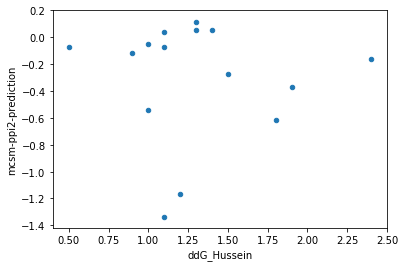

In [171]:
(pd.merge(my.read_mCSM_table('mCSM-PPI2-Predictions/6vw1/jobs/6vw1-ACE2-gnomAD.csv'),
          hussein)
 .plot.scatter(x='ddG_Hussein', y='mcsm-ppi2-prediction')
)